In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [2]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/2023_RVV_1_mask_366.jpg"
mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/mapbox_images_for_frame_366_RVV1"
heli_lat = 50.76401
heli_lon = 3.5411033333333335
# 2 intersections so 2 solutions possible
intersec_lat1 = 50.7654089
intersec_lon1 = 3.54285
intersec_lat2 = 50.7658722
intersec_lon2 = 3.5443585
altitude = 189.88

In [3]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [5]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [6]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, alt) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    # result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    # if not result.empty:
    #    altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {alt}")

    alpha_radian = math.atan2(alt, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [7]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat}_{lon}.jpg", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.jpg")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [8]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [9]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], alt=altitude)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersection: 50.7658722,3.5443585
Bearing = 47.87059954611408
Distance: 308.69109591365395
Altitude: 189.88
Pitch = 58.4037742355779
Intersection: 50.763079,3.5406427
Bearing = 197.3779348272183
Distance: 108.47360796747627
Altitude: 189.88
Pitch = 29.738227514812664
Intersection: 50.764544,3.5377325
Bearing = 284.06224603456843
Distance: 244.40077088651668
Altitude: 189.88
Pitch = 52.15562909179788
Intersection: 50.7654089,3.54285
Bearing = 38.29915628987237
Distance: 198.2096175162896
Altitude: 189.88
Pitch = 46.22955792371023
Intersection: 50.7629072,3.5407101
Bearing = 192.7101679490074
Distance: 125.7060538585783
Altitude: 189.88
Pitch = 33.50571178524681
Intersection: 50.7663914,3.5414129
Bearing = 4.70021834926149
Distance: 265.6931501239538
Altitude: 189.88
Pitch = 54.44816272433146
Intersection: 50.7659298,3.5440658
Bearing = 44.303662188413966
Distance: 298.2977174471809
Altitude: 189.88
Pitch = 57.521401245937255
Intersection: 50.7660379,3.5434854
Bearing = 36.6102034347273

In [10]:
def get_skeleton(mask_bgr, contour) : 
    # print("Getting the skeleton and the pruned skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)
    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh = threshold_otsu(contour_mask_gray)
    contour_mask_gray = contour_mask_gray > thresh
    
    # 1. Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_gray, method='lee').astype(np.uint8)

    np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [11]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # if we have a white pixel
            if image[x][y] == 1:
                neighbours = [image[x-1][y], image[x-1][y-1], image[x][y-1], image[x+1][y-1], image[x+1][y], image[x+1][y+1], image[x][y+1], image[x-1][y+1]]
                if neighbours in validIntersection:
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [12]:
def prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold) : 
    print("Pruning the skeleton")
    pruned_skeleton_contour_bgr = np.zeros_like(skeleton_contour_bgr) 
    bad_contours = []
    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr_help = skeleton_contour_bgr.copy()
        # cv2.circle(pruned_skeleton_contour_bgr_help, (intersection[0], intersection[1]), 1, (0,0,0), -1)
        pruned_skeleton_contour_bgr_help[intersection[1], intersection[0]] = (0,0,0)

        pruned_skeleton_contour_gray_help = cv2.cvtColor(pruned_skeleton_contour_bgr_help, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(pruned_skeleton_contour_gray_help, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours : 
            if cv2.arcLength(contour, closed=False) > threshold :
                cv2.drawContours(pruned_skeleton_contour_bgr, [contour], contourIdx=-1, color=(255, 255, 255), thickness=1)
            else : 
                bad_contours.append(contour)

    for bad_contour in bad_contours :
        cv2.drawContours(pruned_skeleton_contour_bgr, [bad_contour], contourIdx=-1, color=(0, 0, 0), thickness=1)

    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr[intersection[1], intersection[0]] = (255,255,255)
    return pruned_skeleton_contour_bgr    

In [13]:
def get_patch_from_intersection(skel_contour_bgr, intersec, patch_size) : 
    # print("Getting patch from intersection")
    skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate the coordinates of the patch boundaries
    x, y = intersec[0], intersec[1]
    x_min, x_max = x - patch_size // 2, x + patch_size // 2 + 1
    y_min, y_max = y - patch_size // 2, y + patch_size // 2 + 1

    # Ensure the coordinates are within the image bounds
    x_min = max(0, x_min)
    x_max = min(skel_contour_gray.shape[1], x_max)
    y_min = max(0, y_min)
    y_max = min(skel_contour_gray.shape[0], y_max)

    # Extract the patch
    patch = skel_contour_gray[y_min:y_max, x_min:x_max]

    # Patch intersection value
    patch_intersection = (patch.shape[0]//2, patch.shape[1]//2)

    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            if patch[patch_intersection[1]+y, patch_intersection[0]+x] == 255 and (x != 0 or y != 0):
                road_neighbour_pixels.append((patch_intersection[0]+x, patch_intersection[1]+y))

    return patch, road_neighbour_pixels

In [14]:
def find_road_pixels(patch, reference_pixel, neighbour_pixels, intersection, visited_pixels=None):
    if visited_pixels is None:
        visited_pixels = set()

    # print("Finding road pixels")
    # print(f"Intersection = {intersection}")
    patch_size = patch.shape[0]
    road_pixels = []

    for x in range(-1, 2):
        for y in range(-1, 2):
            pixel = (reference_pixel[0] + x, reference_pixel[1] + y)

            # Check if the pixel has been visited or is out of bounds
            if pixel[0] < 0 or pixel[0] >= patch_size or pixel[1] < 0 or pixel[1] >= patch_size or pixel in visited_pixels:
                continue

            # Check if the pixel is a road pixel and not the intersection itself
            if patch[pixel[1], pixel[0]] == 255 and (x != 0 or y != 0) and pixel != intersection and pixel not in neighbour_pixels:
                road_pixels.append(pixel)
                visited_pixels.add(pixel)
                # Recursively search from this pixel
                road_pixels += find_road_pixels(patch, pixel, neighbour_pixels, intersection, visited_pixels)
    
    return road_pixels


In [15]:
def get_descriptor(patch, neighbour_pixels) : 
    # For visualisation purposes
    patch_bgr = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
    
    # Find intersection and set value to 0
    intersection = (patch.shape[0]//2, patch.shape[1]//2)
    patch[intersection[0], intersection[1]] = 0

    angles_vector = []
    
    
    
    # if lines is None : 
    #     print("No houghlines found")
    # else :
    #     for i in range(0, len(lines)):
    #         rho = lines[i][0][0]
    #         theta = lines[i][0][1]
    #         a = math.cos(theta)
    #         b = math.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho
    #         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    #         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    #         cv2.line(patch_bgr, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

    # print("Patch with houghlines")
    # plot_image(patch_bgr)

    for neighbour_pixel in neighbour_pixels :
        road_pixels = find_road_pixels(patch, neighbour_pixel, neighbour_pixels, intersection, None)
        road_pixels.append(neighbour_pixel)
        road_pixels.append(intersection)
        print(f"Road pixels for neighbour pixel {neighbour_pixel} (including intersection): ")
        # print(road_pixels)

        # now append the neighbour pixel AND the intersection pixel to the road pixels 
        # road_pixels.append(intersection)

        # Switch y values because the y axis is inverted
        road_pixels = [(pixel[0], (patch.shape[0]-1) - pixel[1]) for pixel in road_pixels]

        # Adjust the coordinates of road pixels and intersection to be relative to the center
        adjusted_road_pixels = [(pixel[0] - intersection[0], pixel[1] - intersection[1]) for pixel in road_pixels]

        # convert to numpy array
        road_pixels = np.array(adjusted_road_pixels, dtype=np.float32)
        print(f"Road pixels after adjustment (intersection is now origin): ")
        print(road_pixels)


        # For each set of coordinates, compute the best-fit line
        x_values = np.array([coord[0] for coord in road_pixels])
        y_values = np.array([coord[1] for coord in road_pixels])
  

        # Check if all x-values are the same
        all_x_values_same = all(x == x_values[0] for x in x_values)
        if all_x_values_same :
            if neighbour_pixel[1] > intersection[1] :
                angle = 270
            else :
                angle = 90
            angles_vector.append(angle)
            continue

        line = np.polyfit(x_values, y_values, deg=1)
        
        print(f"Line: {line}")

        # Now show the line on the patch
        a = line[0]
        b = line[1]
        y = a * x_values + b
        plt.plot(x_values, y)
        plt.show()

        # The slope of each line gives the direction of the road segment it fits
        angle = np.degrees(np.arctan(a))

        if angle > 0 :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] > intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
        else :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] < intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
            else : 
                angle = angle + 360

        print(f"Direction is: {angle}")
        angles_vector.append(angle)

        # Calculate the direction vector

        # Fit lines using the points
        # vx, vy, x0, y0 = cv2.fitLine(road_pixels, cv2.DIST_L2, 0, 0.01, 0.01)
        # print(f"vx = {vx}, vy = {vy}, x0 = {x0}, y0 = {y0}")

        # direction_vector = (vx[0], vy[0])

        # # Calculate the angle in radians
        # angle_radians = math.atan2(vy[0], vx[0])

        # # Convert the angle to degrees
        # angle_degrees = math.degrees(angle_radians)

        # print(f"Angle: {angle_degrees} degrees")

        # direction_vectors.append(direction_vector)
    
    # print(f"Direction vectors: {angles_vector}")
    # sort direction_vectors from small to big
    angles_vector_sorted = sorted(angles_vector)
    print(f"Sorted vector of angles: {angles_vector_sorted}")

    descriptor = angles_vector_sorted

    # descriptor = []
    # # define a descriptor based on angles_vector_sorted
    # for i in range(1, len(angles_vector_sorted)): 
    #     angle_ratio = angles_vector_sorted[i] / angles_vector_sorted[0]
    #     descriptor.append(angle_ratio) 
        
    # print(f"Descriptor = {descriptor}")
    
    return descriptor


In [16]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                
                # prune the skeleton to remove small branches
                threshold = 300
                pruned_skeleton_contour_bgr = prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold)
                plot_image(pruned_skeleton_contour_bgr)
                
                # now find the possible intersection, if there is one
                pruned_skel_intersections = get_skeleton_intersection(pruned_skeleton_contour_bgr)

                # further processing
                if pruned_skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    pruned_skeleton_contour_bgr_copy = pruned_skeleton_contour_bgr.copy()
                    for intersection in pruned_skel_intersections :
                        pruned_skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for prune_intersection in pruned_skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(pruned_skeleton_contour_bgr, prune_intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

In [17]:
def find_descriptors_in_segmentation_image_without_pruning(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(closing_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

Finding descriptors in segmentation image
Segmentation image


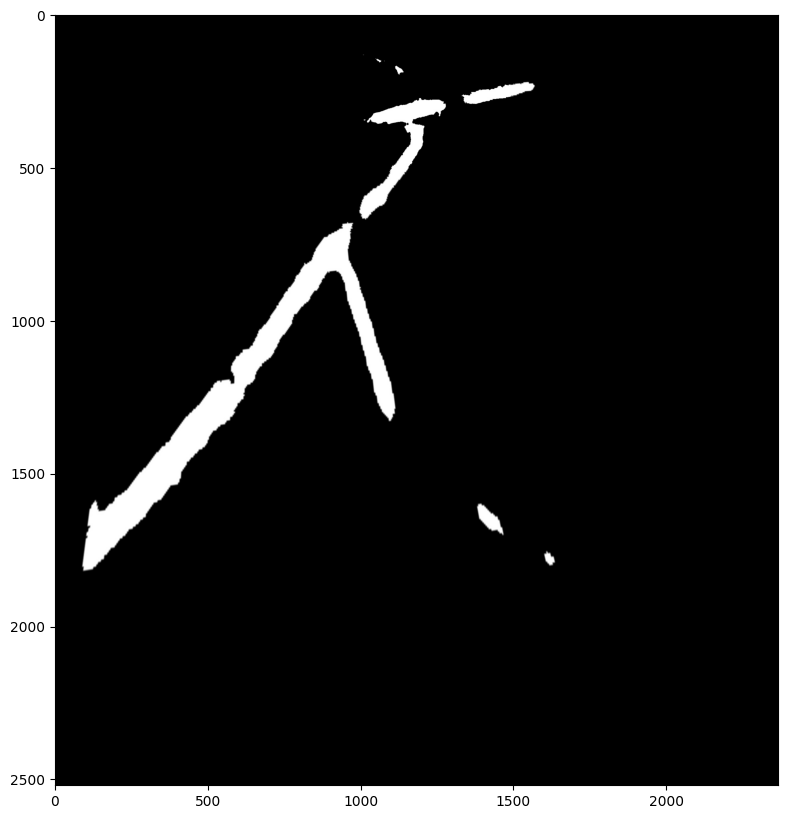

Isotropic closing of segmentation image


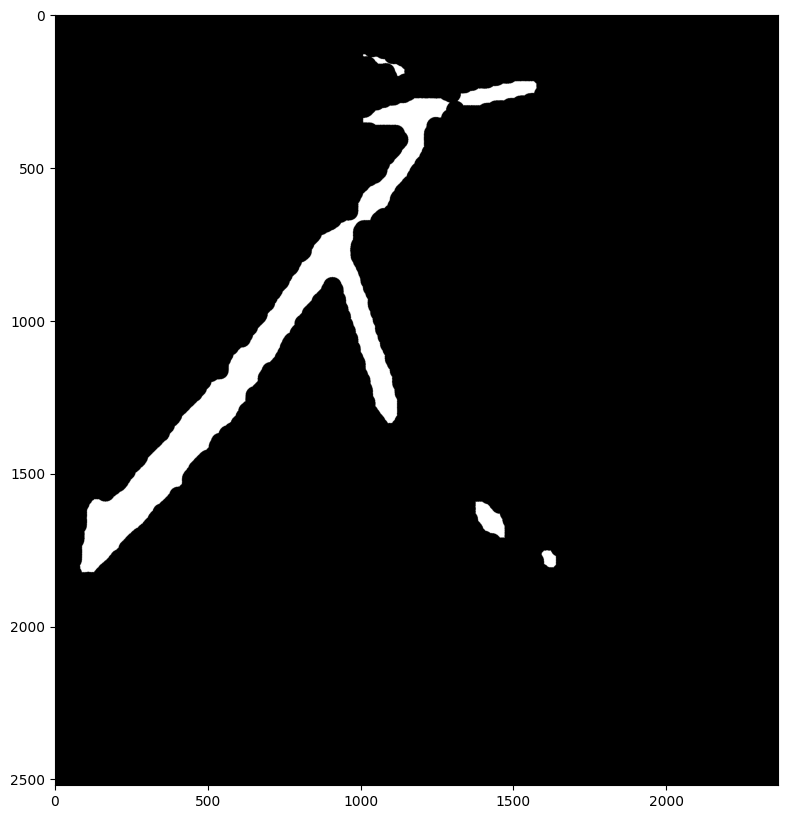

Number of contours: 6
Contour length: 190.2081515789032
Contour area: 1855.5
Convex hull area: 2043.0


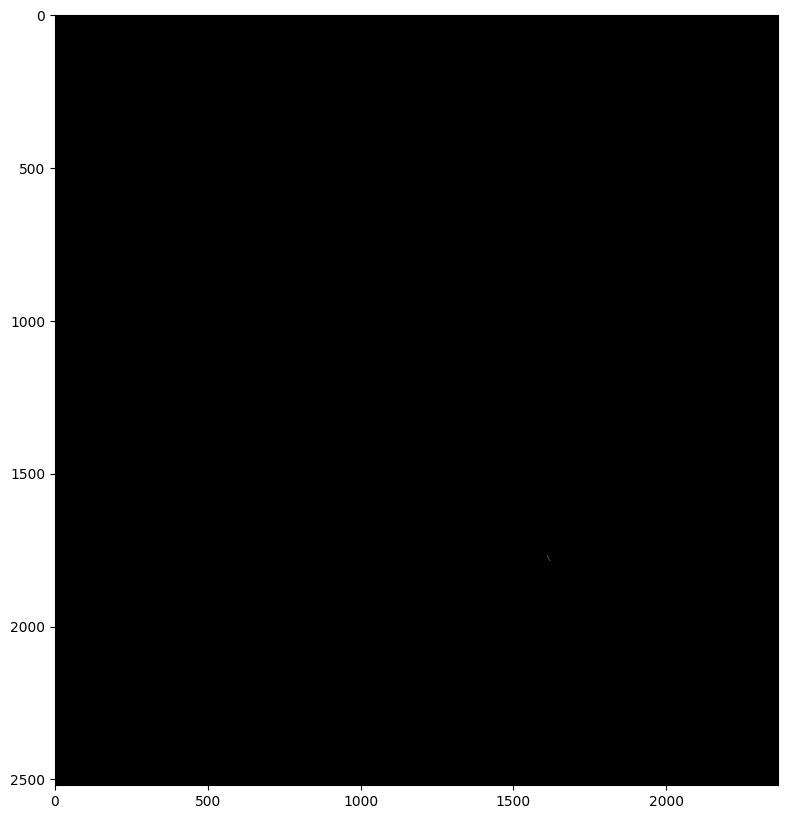

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.908223201174743 -> no intersection in this contour
Contour length: 384.85995411872864
Contour area: 6597.5
Convex hull area: 7176.5


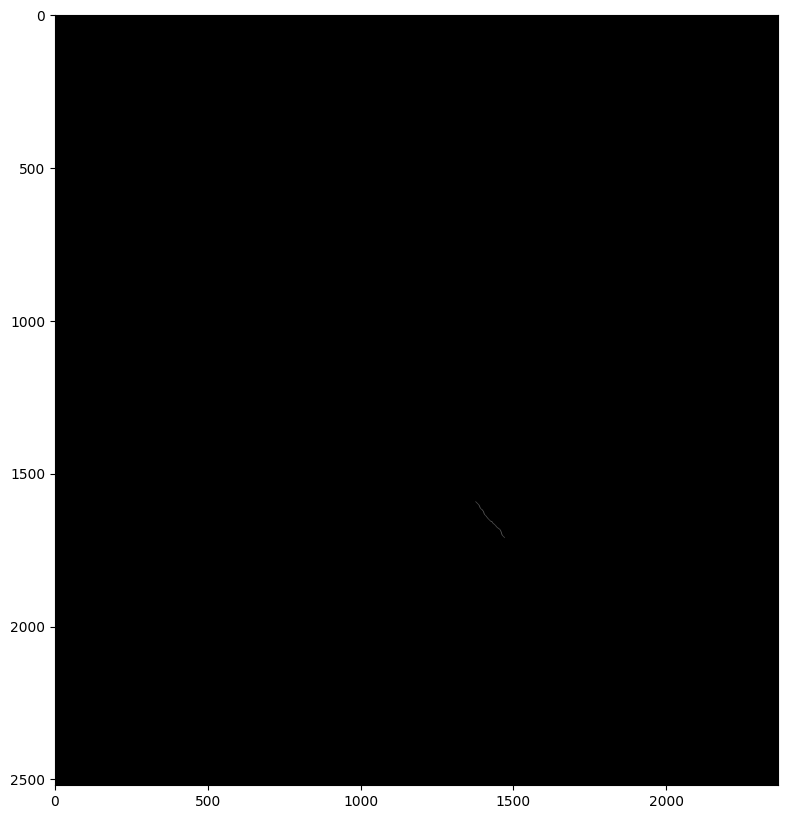

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.9193200027868739 -> no intersection in this contour
Contour length: 5969.339994549751
Contour area: 223305.5
Convex hull area: 778771.5


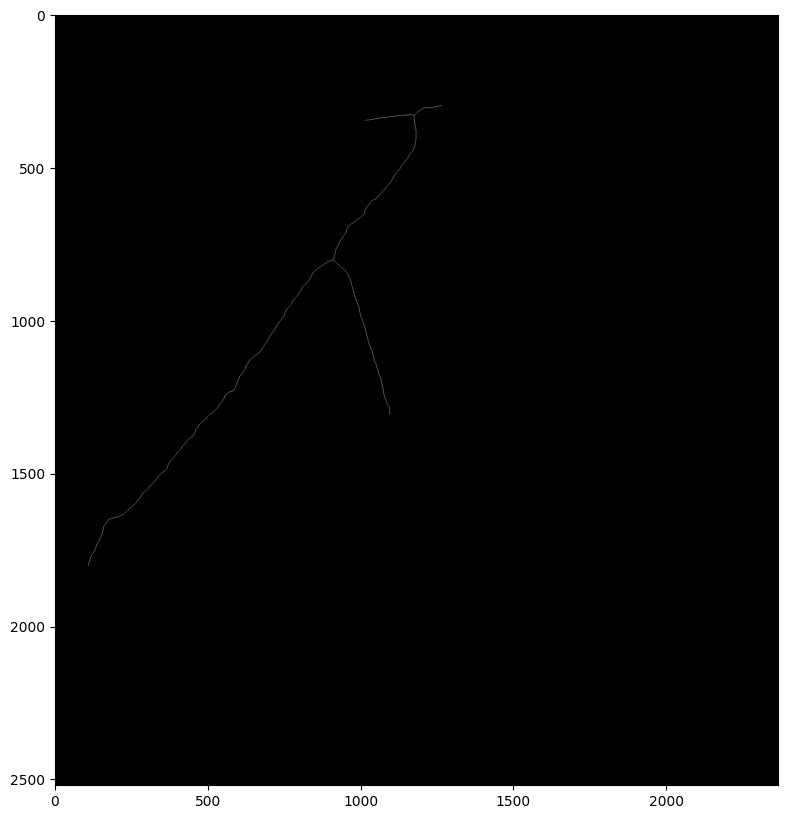

Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.2867407191968376 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
Road neighbour pixels: [(14, 14), (15, 16), (16, 14)]
Number of roads that intersect in this intersection: 3
Patch:


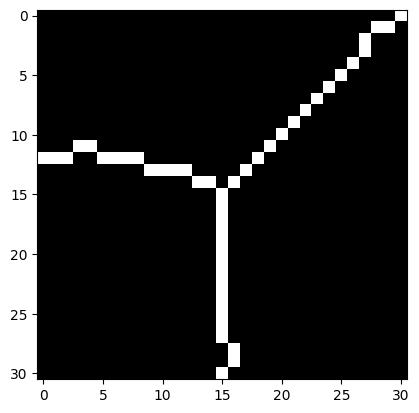

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 255]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 255 255   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 255   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 255   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 2

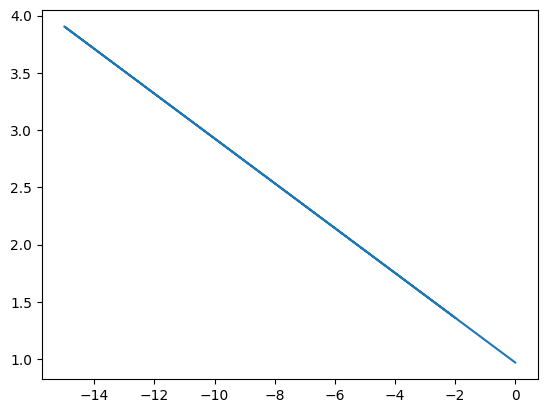

Direction is: 168.93332581319532
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [  0.  -4.]
 [  0.  -5.]
 [  0.  -6.]
 [  0.  -7.]
 [  0.  -8.]
 [  0.  -9.]
 [  0. -10.]
 [  0. -11.]
 [  0. -12.]
 [  1. -13.]
 [  1. -14.]
 [  0. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-6.85714286 -6.64285714]


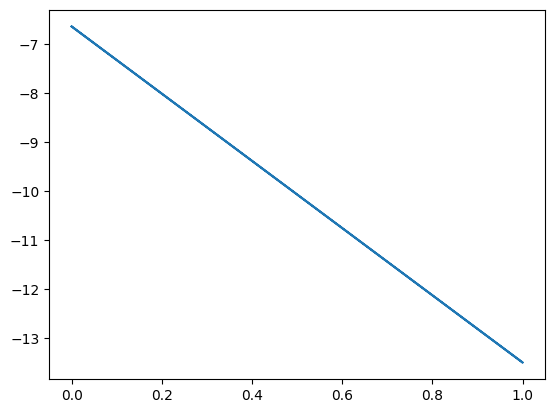

Direction is: 278.29714496983684
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  7.]
 [ 8.  8.]
 [ 9.  9.]
 [10. 10.]
 [11. 11.]
 [12. 12.]
 [12. 13.]
 [13. 14.]
 [14. 14.]
 [15. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 1.02637615 -0.08715596]


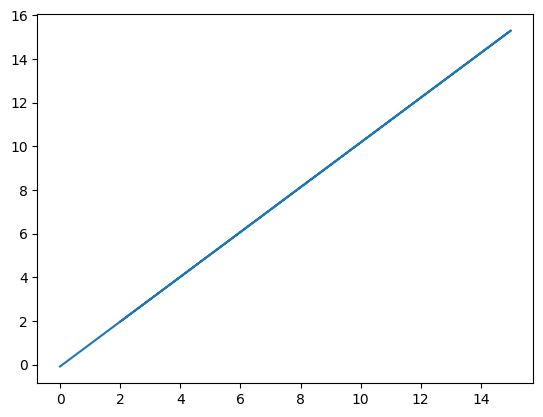

Direction is: 45.745743357427784
Sorted vector of angles: [45.745743357427784, 168.93332581319532, 278.29714496983684]
Road neighbour pixels: [(14, 16), (16, 14), (16, 16)]
Number of roads that intersect in this intersection: 3
Patch:


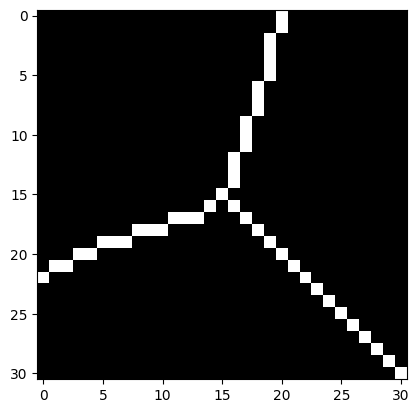

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 255   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  255   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  255   0   0   0   0  

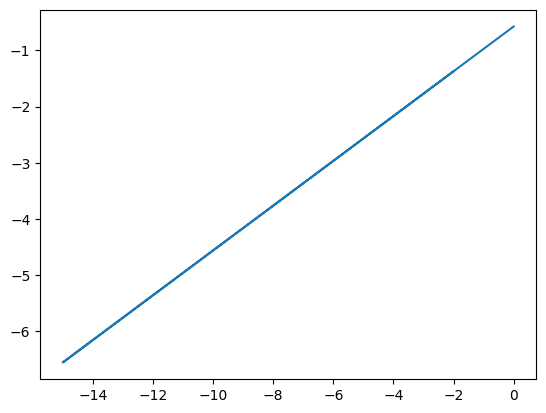

Direction is: 201.72873603532827
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 1.  3.]
 [ 2.  4.]
 [ 2.  5.]
 [ 2.  6.]
 [ 3.  7.]
 [ 3.  8.]
 [ 3.  9.]
 [ 4. 10.]
 [ 4. 11.]
 [ 4. 12.]
 [ 4. 13.]
 [ 5. 14.]
 [ 5. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 3.05714286 -0.90714286]


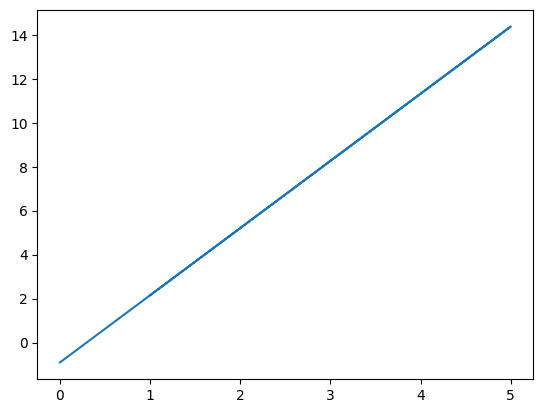

Direction is: 71.88693419247672
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -8.]
 [  9.  -9.]
 [ 10. -10.]
 [ 11. -11.]
 [ 12. -12.]
 [ 13. -13.]
 [ 14. -14.]
 [ 15. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.00000000e+00 -3.06836907e-15]


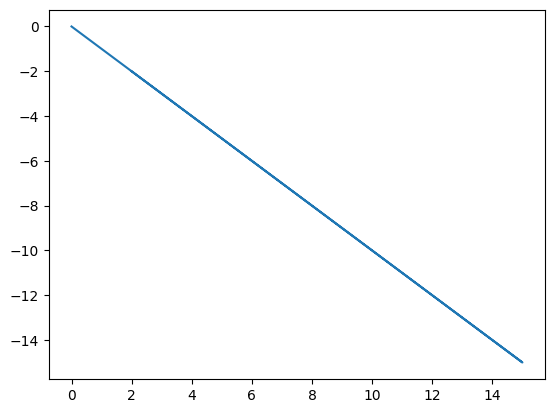

Direction is: 315.0
Sorted vector of angles: [71.88693419247672, 201.72873603532827, 315.0]
Contour length: 663.5950144529343
Contour area: 11185.5
Convex hull area: 12564.0


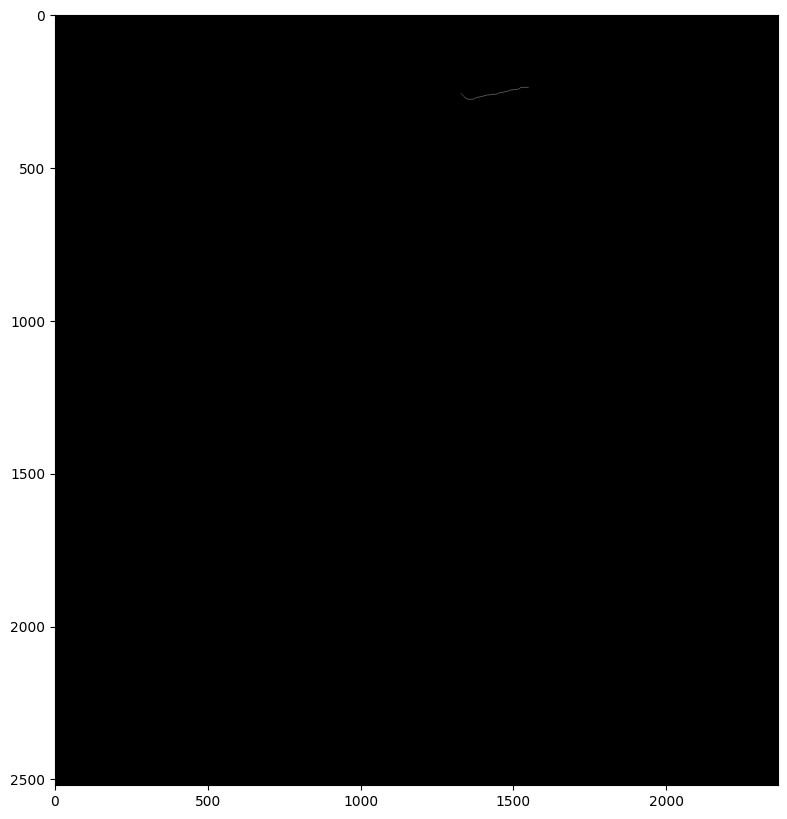

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.8902817574021012 -> no intersection in this contour
Contour length: 299.36248004436493
Contour area: 1467.0
Convex hull area: 2727.5


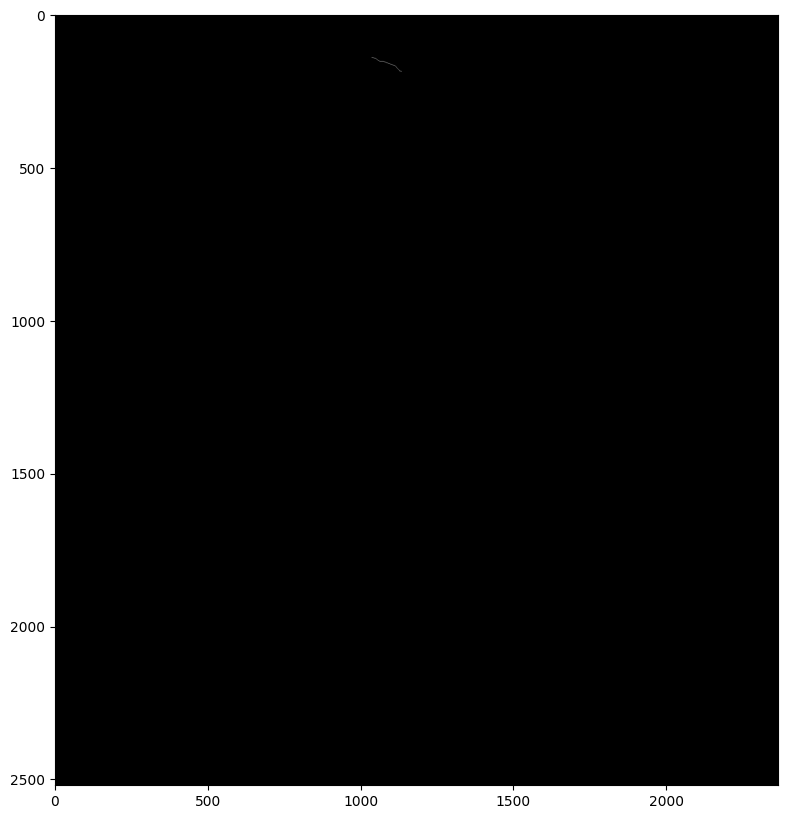

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.5378551787351054 -> no intersection in this contour
Contour length: 42.284270882606506
Contour area: 51.0
Convex hull area: 70.5


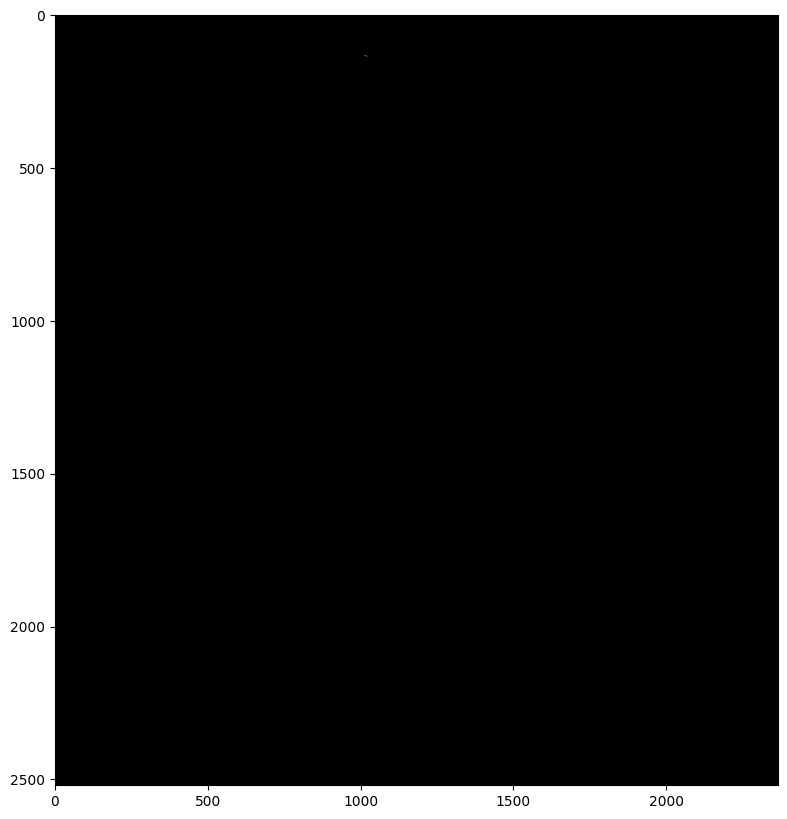

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.723404255319149 -> no intersection in this contour
Array of descriptors: [[45.745743357427784, 168.93332581319532, 278.29714496983684], [71.88693419247672, 201.72873603532827, 315.0]]


In [18]:
# segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path)
segm_img_des = find_descriptors_in_segmentation_image_without_pruning(sem_segm_img_path)
print(f"Array of descriptors: {segm_img_des}")

In [19]:
def find_descriptors_in_mapbox_image(img_path, image_name) : 
    print(f"Finding descriptors in mapbox image {image_name}")
    
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    # print("Cropped mapbox image")
    # plot_image(cropped_img_bgr)

    # print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(thresh_bgr)

    thresh_bgr_copy = thresh_bgr.copy()

    contours, hierarchy = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(f"Number of contours: {len(contours)}")
    # cv2.drawContours(thresh_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        # print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        # print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            # print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            if convex_hull_area != 0 :
                solidity = contour_area / convex_hull_area
            else :
                solidity = 0

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(thresh_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")

            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        # print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        # print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        # print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        # print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.7654089_3.54285.jpg
**************************************************
Finding descriptors in mapbox image 50.7654089_3.54285.jpg
Getting intersections in skeleton (more than 2 neighbours)
3 intersections found in the skeleton
Solidity = 0.458959075241378 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images


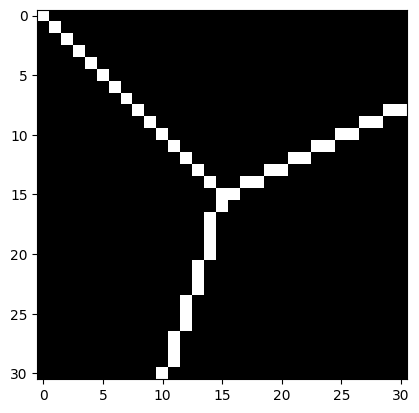

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   6.]
 [ -7.   7.]
 [ -8.   8.]
 [ -9.   9.]
 [-10.  10.]
 [-11.  11.]
 [-12.  12.]
 [-13.  13.]
 [-14.  14.]
 [-15.  15.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-1.00000000e+00  3.06836907e-15]


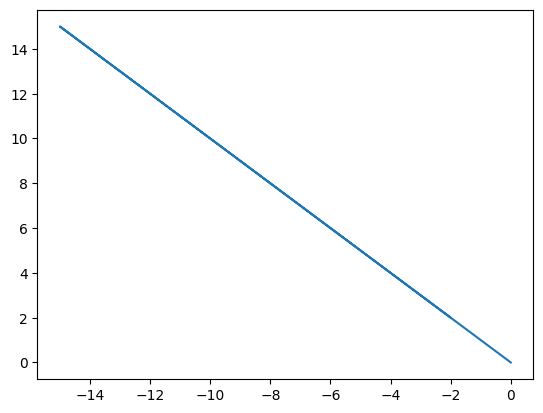

Direction is: 135.0
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -2.  -8.]
 [ -3.  -9.]
 [ -3. -10.]
 [ -3. -11.]
 [ -4. -12.]
 [ -4. -13.]
 [ -4. -14.]
 [ -5. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 3.05714286 -0.62142857]


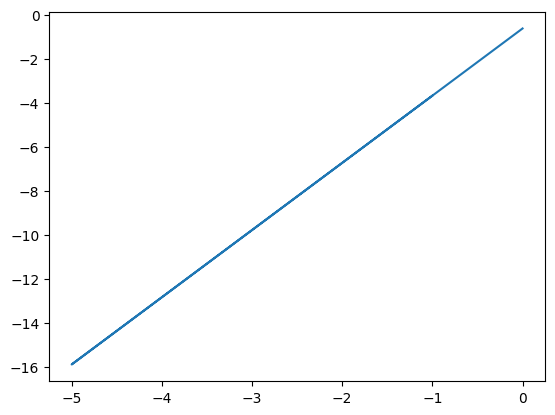

Direction is: 251.8869341924767
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  3.]
 [ 7.  3.]
 [ 8.  4.]
 [ 9.  4.]
 [10.  5.]
 [11.  5.]
 [12.  6.]
 [13.  6.]
 [14.  7.]
 [15.  7.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 0.49411765 -0.20588235]


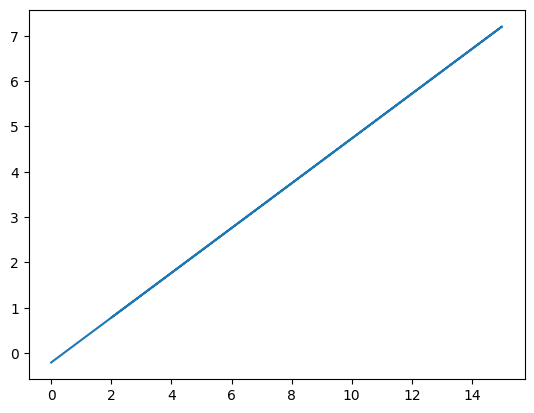

Direction is: 26.294790070583854
Sorted vector of angles: [26.294790070583854, 135.0, 251.8869341924767]


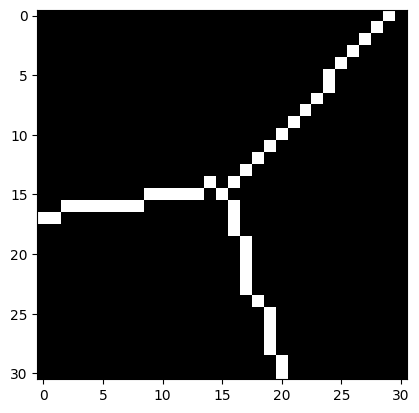

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   0.]
 [ -5.   0.]
 [ -6.   0.]
 [ -7.  -1.]
 [ -8.  -1.]
 [ -9.  -1.]
 [-10.  -1.]
 [-11.  -1.]
 [-12.  -1.]
 [-13.  -1.]
 [-14.  -2.]
 [-15.  -2.]
 [ -1.   1.]
 [  0.   0.]]
Line: [0.15294118 0.52205882]


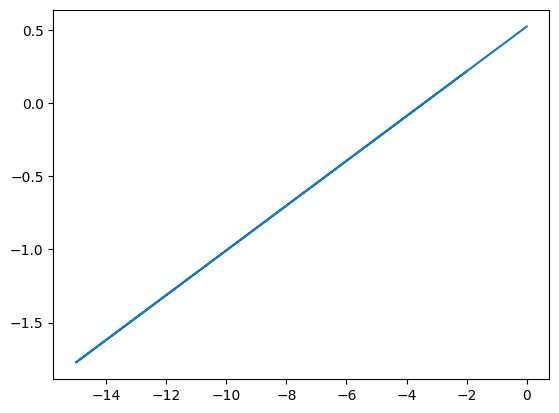

Direction is: 188.69550287742476
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  7.]
 [ 8.  8.]
 [ 9.  9.]
 [ 9. 10.]
 [10. 11.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 1.09251101 -0.28414097]


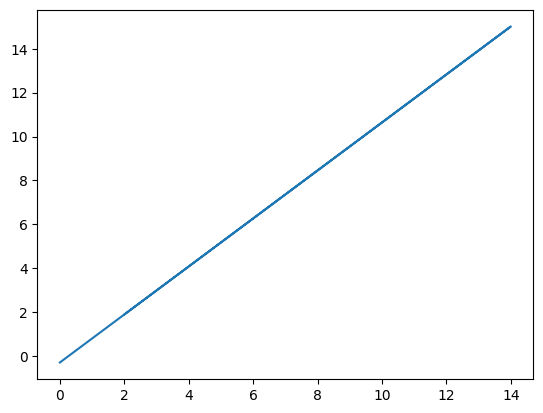

Direction is: 47.531428141667675
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  2.  -7.]
 [  2.  -8.]
 [  3.  -9.]
 [  4. -10.]
 [  4. -11.]
 [  4. -12.]
 [  4. -13.]
 [  5. -14.]
 [  5. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-2.99300699  0.35664336]


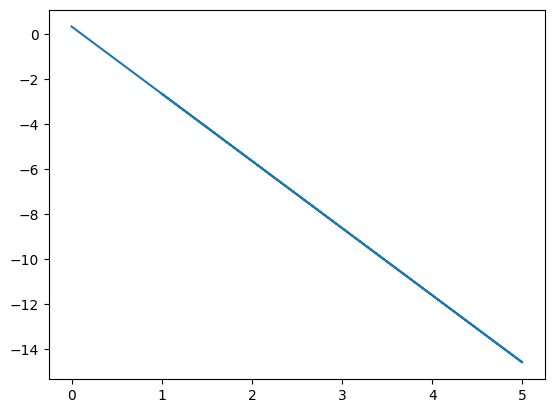

Direction is: 288.4751000283419
Sorted vector of angles: [47.531428141667675, 188.69550287742476, 288.4751000283419]


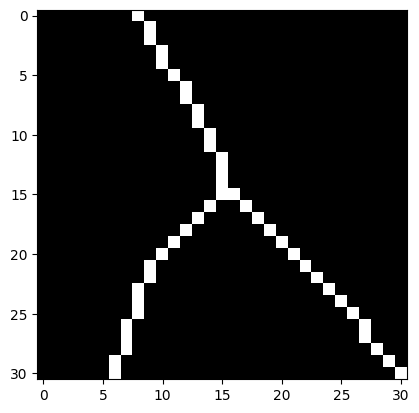

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -5.  -5.]
 [ -6.  -6.]
 [ -6.  -7.]
 [ -7.  -8.]
 [ -7.  -9.]
 [ -7. -10.]
 [ -8. -11.]
 [ -8. -12.]
 [ -8. -13.]
 [ -9. -14.]
 [ -9. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.60985626 1.55544148]


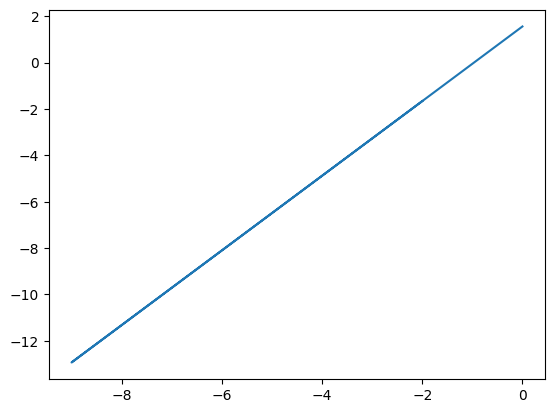

Direction is: 238.15254664442307
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [-1.  4.]
 [-1.  5.]
 [-2.  6.]
 [-2.  7.]
 [-3.  8.]
 [-3.  9.]
 [-4. 10.]
 [-5. 11.]
 [-5. 12.]
 [-6. 13.]
 [-6. 14.]
 [-7. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-1.92791519  2.07773852]


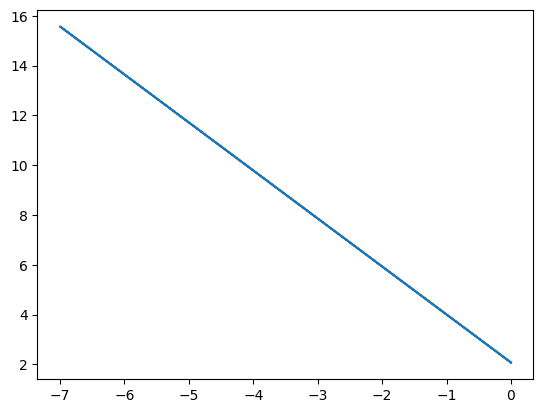

Direction is: 117.41554459375601
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -1.]
 [  3.  -2.]
 [  4.  -3.]
 [  5.  -4.]
 [  6.  -5.]
 [  7.  -6.]
 [  8.  -7.]
 [  9.  -8.]
 [ 10.  -9.]
 [ 11. -10.]
 [ 12. -11.]
 [ 12. -12.]
 [ 13. -13.]
 [ 14. -14.]
 [ 15. -15.]
 [  1.   0.]
 [  0.   0.]]
Line: [-1.04226737  1.03407602]


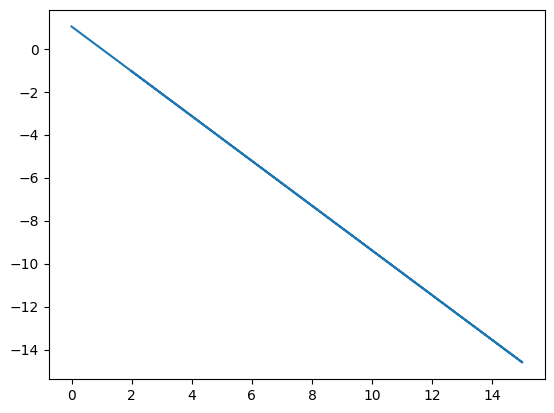

Direction is: 313.8143589719959
Sorted vector of angles: [117.41554459375601, 238.15254664442307, 313.8143589719959]
Descriptors: [[26.294790070583854, 135.0, 251.8869341924767], [47.531428141667675, 188.69550287742476, 288.4751000283419], [117.41554459375601, 238.15254664442307, 313.8143589719959]] for mapbox image 50.7654089_3.54285.jpg
Number of descriptors: 3
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[26.294790070583854, 135.0, 251.8869341924767]
x = 45.745743357427784, y = 26.294790070583854
x = 168.93332581319532, y = 135.0
x = 278.29714496983684, y = 251.8869341924767
Result = 47.194379091328685
Descriptor of mapbox image:
[47.531428141667675, 188.69550287742476, 288.4751000283419]
x = 45.745743357427784, y = 47.531428141667675
x = 168.93332581319532, y = 188.69550287742476
x = 278.29714496983684, y = 288.4751000283419
Result = 22.300741728462096
Descriptor of mapbox image:
[117.41554459375601, 238.

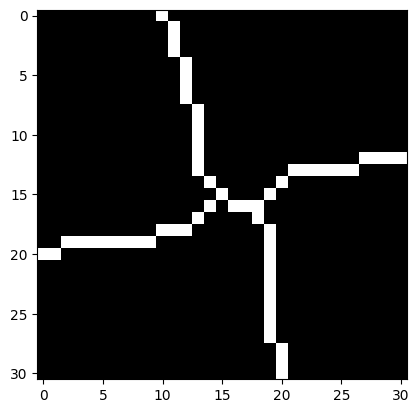

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-2.  2.]
 [-2.  3.]
 [-2.  4.]
 [-2.  5.]
 [-2.  6.]
 [-2.  7.]
 [-3.  8.]
 [-3.  9.]
 [-3. 10.]
 [-3. 11.]
 [-4. 12.]
 [-4. 13.]
 [-4. 14.]
 [-5. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-3.57894737 -1.89473684]


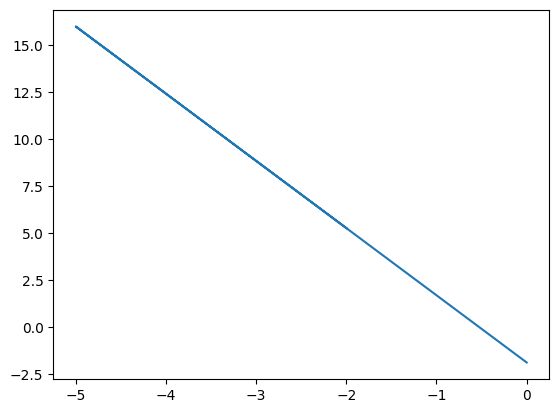

Direction is: 105.61098853367966
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -3.]
 [ -5.  -3.]
 [ -6.  -4.]
 [ -7.  -4.]
 [ -8.  -4.]
 [ -9.  -4.]
 [-10.  -4.]
 [-11.  -4.]
 [-12.  -4.]
 [-13.  -4.]
 [-14.  -5.]
 [-15.  -5.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.25 -1.5 ]


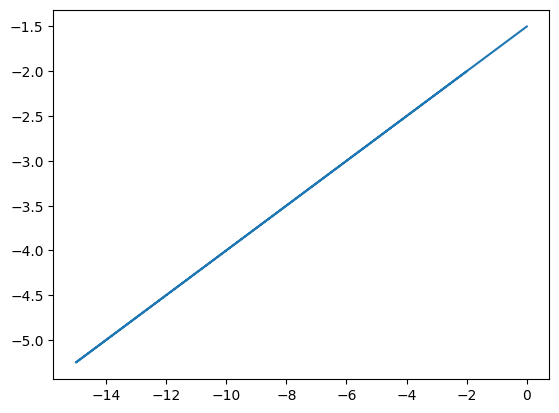

Direction is: 194.03624346792648
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -1.]
 [  3.  -1.]
 [  3.  -2.]
 [  4.  -3.]
 [  4.  -4.]
 [  4.  -5.]
 [  4.  -6.]
 [  4.  -7.]
 [  4.  -8.]
 [  4.  -9.]
 [  4. -10.]
 [  4. -11.]
 [  4. -12.]
 [  5. -13.]
 [  5. -14.]
 [  5. -15.]
 [  4.   0.]
 [  5.   1.]
 [  6.   2.]
 [  7.   2.]
 [  8.   2.]
 [  9.   2.]
 [ 10.   2.]
 [ 11.   2.]
 [ 12.   3.]
 [ 13.   3.]
 [ 14.   3.]
 [ 15.   3.]
 [  1.  -1.]
 [  0.   0.]]
Line: [ 0.75381739 -7.70598317]


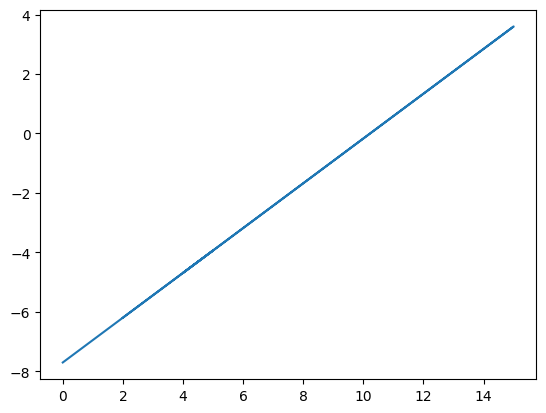

Direction is: 37.009622307702074
Sorted vector of angles: [37.009622307702074, 105.61098853367966, 194.03624346792648]


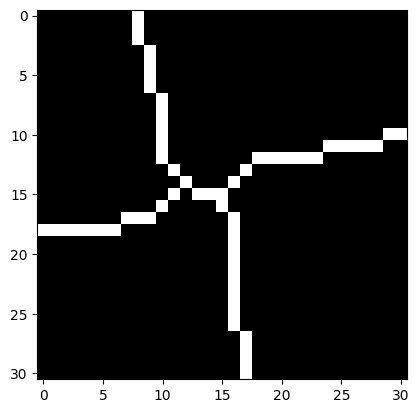

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   1.]
 [ -4.   2.]
 [ -5.   3.]
 [ -5.   4.]
 [ -5.   5.]
 [ -5.   6.]
 [ -5.   7.]
 [ -5.   8.]
 [ -6.   9.]
 [ -6.  10.]
 [ -6.  11.]
 [ -6.  12.]
 [ -7.  13.]
 [ -7.  14.]
 [ -7.  15.]
 [ -4.   0.]
 [ -5.  -1.]
 [ -6.  -2.]
 [ -7.  -2.]
 [ -8.  -2.]
 [ -9.  -3.]
 [-10.  -3.]
 [-11.  -3.]
 [-12.  -3.]
 [-13.  -3.]
 [-14.  -3.]
 [-15.  -3.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.49677248 6.36192413]


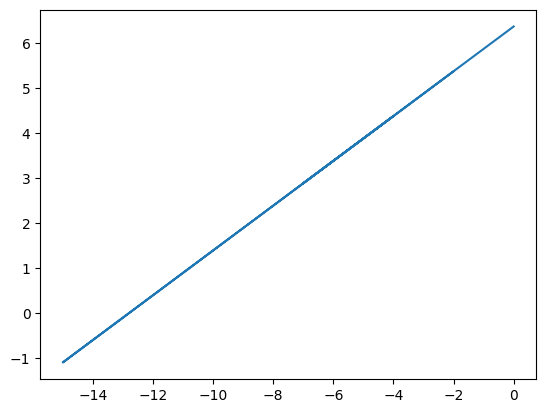

Direction is: 206.41692174707322
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  1.  -7.]
 [  1.  -8.]
 [  1.  -9.]
 [  1. -10.]
 [  1. -11.]
 [  2. -12.]
 [  2. -13.]
 [  2. -14.]
 [  2. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-6.60869565 -0.06521739]


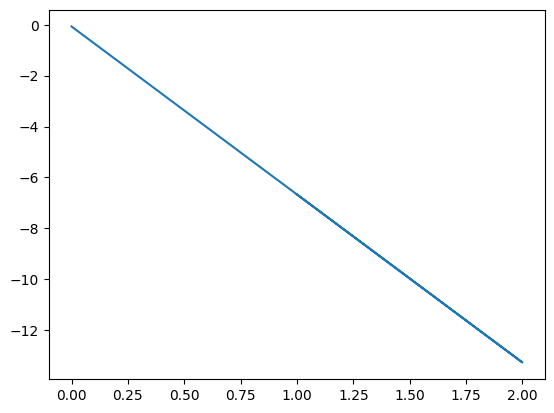

Direction is: 278.60448159309266
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 7.  3.]
 [ 8.  3.]
 [ 9.  4.]
 [10.  4.]
 [11.  4.]
 [12.  4.]
 [13.  4.]
 [14.  5.]
 [15.  5.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.25441176 1.27941176]


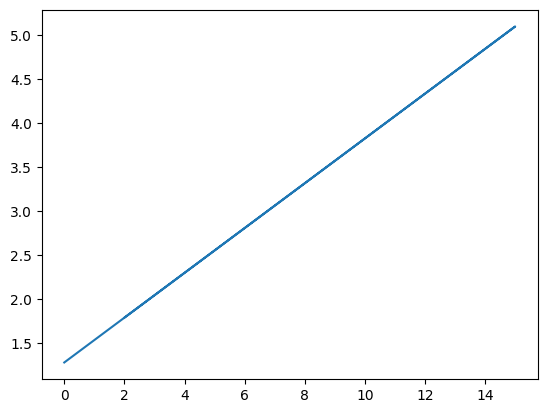

Direction is: 14.27390175033323
Sorted vector of angles: [14.27390175033323, 206.41692174707322, 278.60448159309266]


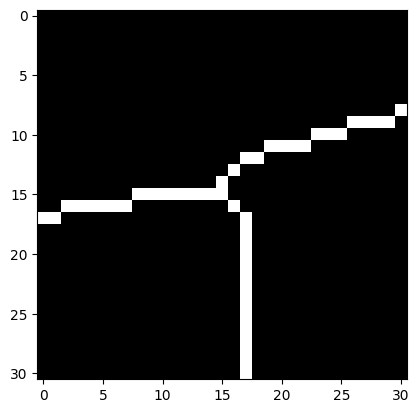

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   0.]
 [ -5.   0.]
 [ -6.   0.]
 [ -7.   0.]
 [ -8.  -1.]
 [ -9.  -1.]
 [-10.  -1.]
 [-11.  -1.]
 [-12.  -1.]
 [-13.  -1.]
 [-14.  -2.]
 [-15.  -2.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.13529412 0.38970588]


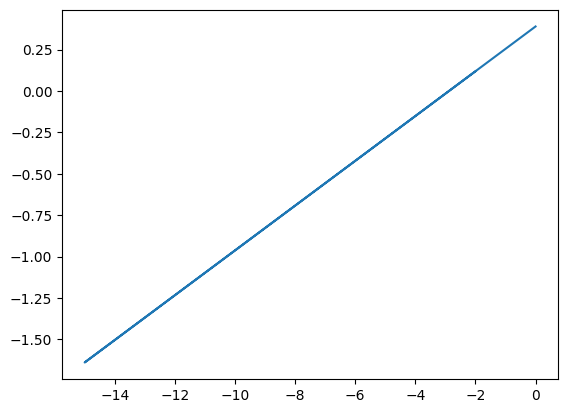

Direction is: 187.70499719883898
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 2.  3.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  4.]
 [ 7.  4.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  5.]
 [11.  6.]
 [12.  6.]
 [13.  6.]
 [14.  6.]
 [15.  7.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [0.36601796 1.59281437]


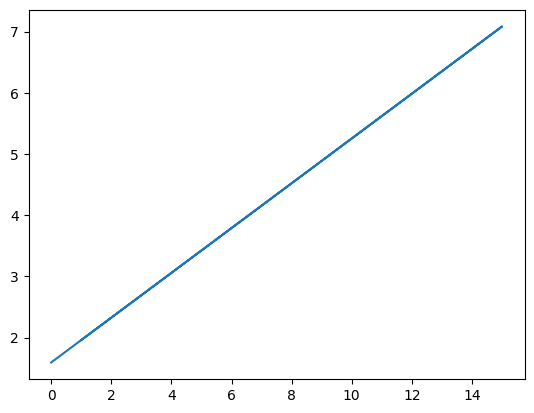

Direction is: 20.103533457397386
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  2.  -7.]
 [  2.  -8.]
 [  2.  -9.]
 [  2. -10.]
 [  2. -11.]
 [  2. -12.]
 [  2. -13.]
 [  2. -14.]
 [  2. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-4.84507042  1.28169014]


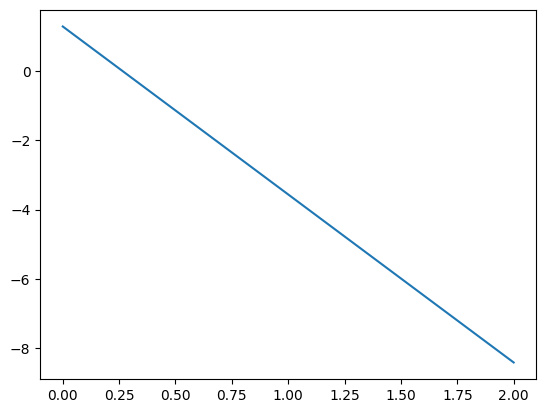

Direction is: 281.66182842601586
Sorted vector of angles: [20.103533457397386, 187.70499719883898, 281.66182842601586]
Descriptors: [[37.009622307702074, 105.61098853367966, 194.03624346792648], [14.27390175033323, 206.41692174707322, 278.60448159309266], [20.103533457397386, 187.70499719883898, 281.66182842601586]] for mapbox image 50.7659298_3.5440658.jpg
Number of descriptors: 3
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[37.009622307702074, 105.61098853367966, 194.03624346792648]
x = 45.745743357427784, y = 37.009622307702074
x = 168.93332581319532, y = 105.61098853367966
x = 278.29714496983684, y = 194.03624346792648
Result = 105.76359360125221
Descriptor of mapbox image:
[14.27390175033323, 206.41692174707322, 278.60448159309266]
x = 45.745743357427784, y = 14.27390175033323
x = 168.93332581319532, y = 206.41692174707322
x = 278.29714496983684, y = 278.60448159309266
Result = 48.94477739326505
Descrip

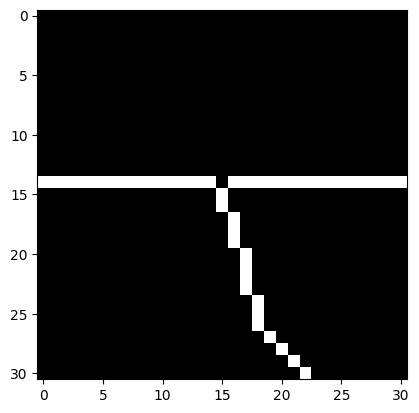

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   1.]
 [ -8.   1.]
 [ -9.   1.]
 [-10.   1.]
 [-11.   1.]
 [-12.   1.]
 [-13.   1.]
 [-14.   1.]
 [-15.   1.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.02205882  0.77205882]


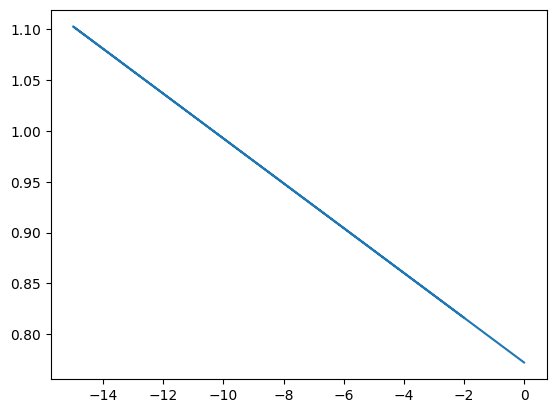

Direction is: 178.73632744834174
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  2.  -7.]
 [  2.  -8.]
 [  3.  -9.]
 [  3. -10.]
 [  3. -11.]
 [  4. -12.]
 [  5. -13.]
 [  6. -14.]
 [  7. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-2.23481781 -1.63360324]


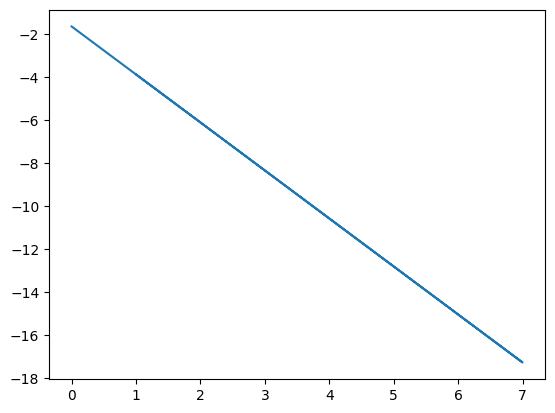

Direction is: 294.1067863009143
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 9.  1.]
 [10.  1.]
 [11.  1.]
 [12.  1.]
 [13.  1.]
 [14.  1.]
 [15.  1.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.02205882 0.77205882]


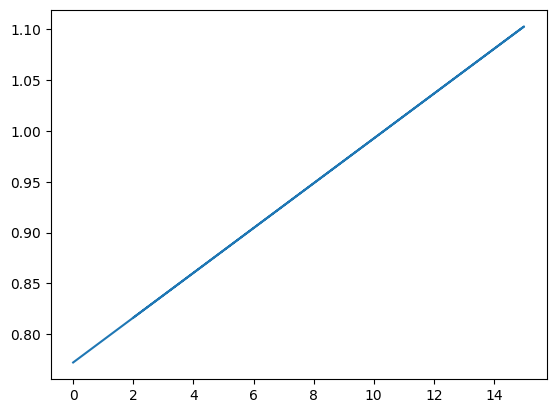

Direction is: 1.2636725516582665
Sorted vector of angles: [1.2636725516582665, 178.73632744834174, 294.1067863009143]
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.8898426323319027 -> no intersection in this contour
Descriptors: [[1.2636725516582665, 178.73632744834174, 294.1067863009143]] for mapbox image 50.7662767_3.54213.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[1.2636725516582665, 178.73632744834174, 294.1067863009143]
x = 45.745743357427784, y = 1.2636725516582665
x = 168.93332581319532, y = 178.73632744834174
x = 278.29714496983684, y = 294.1067863009143
Result = 48.21512442424564
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.0]
Descriptor of mapbox image:
[1.2636725516582665, 178.73632744834174, 294.1067863009143]
x = 71.88693419247672, y = 1.2636725516582665
x = 201.7287360

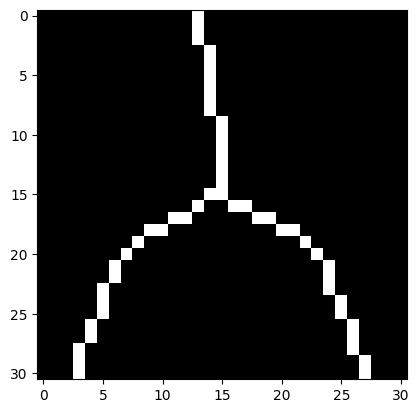

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -2.]
 [ -4.  -2.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -4.]
 [ -8.  -5.]
 [ -9.  -6.]
 [ -9.  -7.]
 [-10.  -8.]
 [-10.  -9.]
 [-10. -10.]
 [-11. -11.]
 [-11. -12.]
 [-12. -13.]
 [-12. -14.]
 [-12. -15.]
 [ -1.   0.]
 [  0.   0.]]
Line: [1.17239426 2.1831571 ]


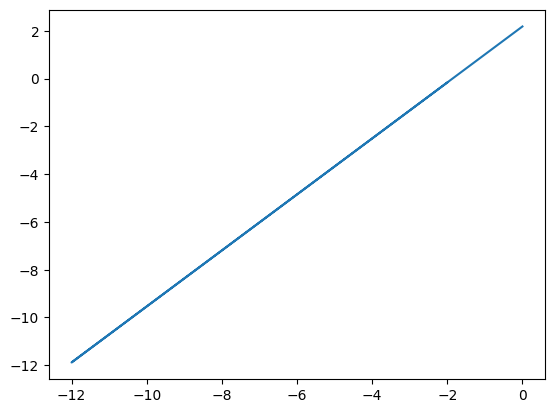

Direction is: 229.53730118338848
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [-1.  7.]
 [-1.  8.]
 [-1.  9.]
 [-1. 10.]
 [-1. 11.]
 [-1. 12.]
 [-2. 13.]
 [-2. 14.]
 [-2. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-5.66666667  3.25      ]


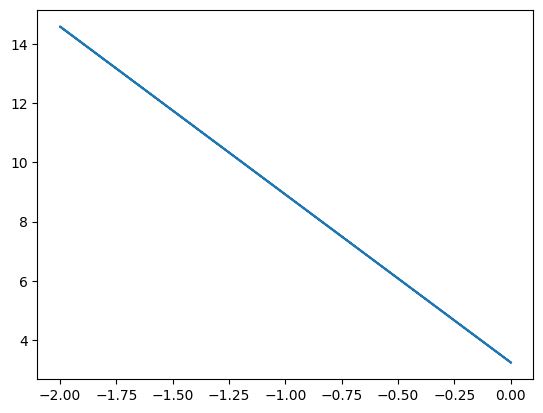

Direction is: 100.00797980144134
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -1.]
 [  3.  -2.]
 [  4.  -2.]
 [  5.  -3.]
 [  6.  -3.]
 [  7.  -4.]
 [  8.  -5.]
 [  9.  -6.]
 [  9.  -7.]
 [  9.  -8.]
 [ 10.  -9.]
 [ 10. -10.]
 [ 11. -11.]
 [ 11. -12.]
 [ 11. -13.]
 [ 12. -14.]
 [ 12. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.17325168  2.01343343]


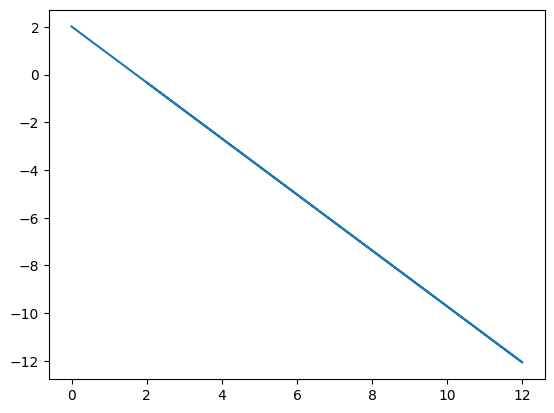

Direction is: 310.44201844256463
Sorted vector of angles: [100.00797980144134, 229.53730118338848, 310.44201844256463]
Descriptors: [[100.00797980144134, 229.53730118338848, 310.44201844256463]] for mapbox image 50.7645454_3.5376782.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[100.00797980144134, 229.53730118338848, 310.44201844256463]
x = 45.745743357427784, y = 100.00797980144134
x = 168.93332581319532, y = 229.53730118338848
x = 278.29714496983684, y = 310.44201844256463
Result = 87.46727974022451
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.0]
Descriptor of mapbox image:
[100.00797980144134, 229.53730118338848, 310.44201844256463]
x = 71.88693419247672, y = 100.00797980144134
x = 201.72873603532827, y = 229.53730118338848
x = 315.0, y = 310.44201844256463
Result = 39.81061036474194
**************************************************
Mapbox imag

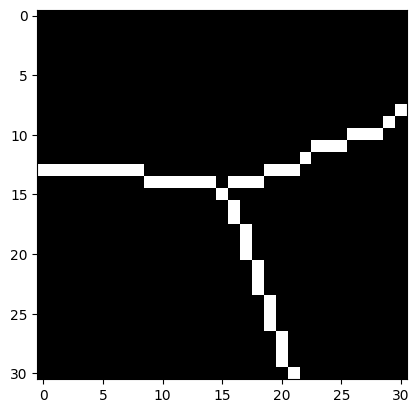

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   2.]
 [ -8.   2.]
 [ -9.   2.]
 [-10.   2.]
 [-11.   2.]
 [-12.   2.]
 [-13.   2.]
 [-14.   2.]
 [-15.   2.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.11470588  0.63970588]


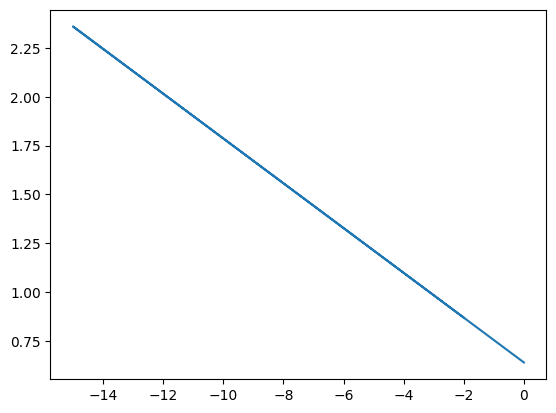

Direction is: 173.4564358992106
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  3.]
 [ 8.  4.]
 [ 9.  4.]
 [10.  4.]
 [11.  5.]
 [12.  5.]
 [13.  5.]
 [14.  6.]
 [15.  7.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.42352941 0.07352941]


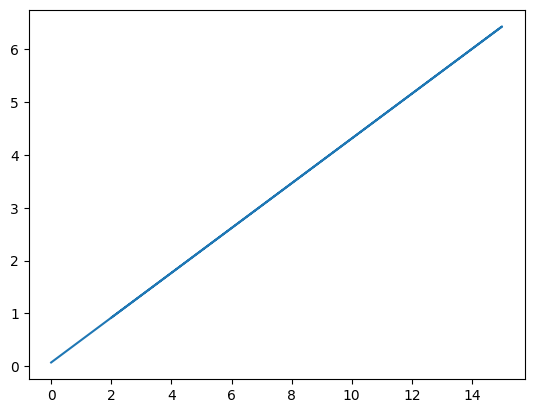

Direction is: 22.954086537628477
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  3.  -6.]
 [  3.  -7.]
 [  3.  -8.]
 [  4.  -9.]
 [  4. -10.]
 [  4. -11.]
 [  5. -12.]
 [  5. -13.]
 [  5. -14.]
 [  6. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-2.74285714  1.07142857]


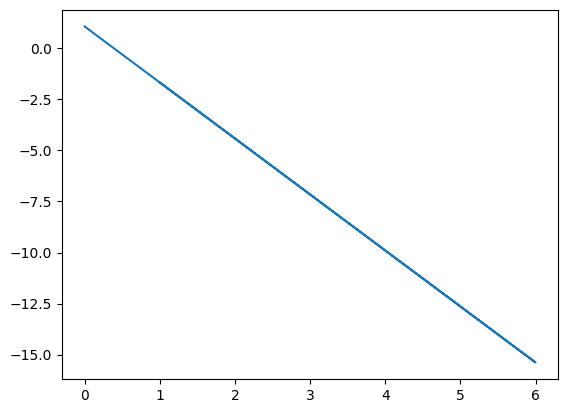

Direction is: 290.03101268089773
Sorted vector of angles: [22.954086537628477, 173.4564358992106, 290.03101268089773]


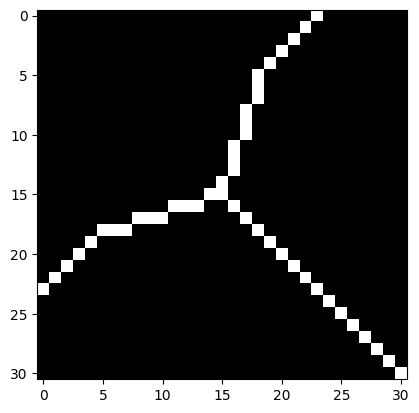

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -1.]
 [ -5.  -2.]
 [ -6.  -2.]
 [ -7.  -2.]
 [ -8.  -3.]
 [ -9.  -3.]
 [-10.  -3.]
 [-11.  -4.]
 [-12.  -5.]
 [-13.  -6.]
 [-14.  -7.]
 [-15.  -8.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.48823529 0.66176471]


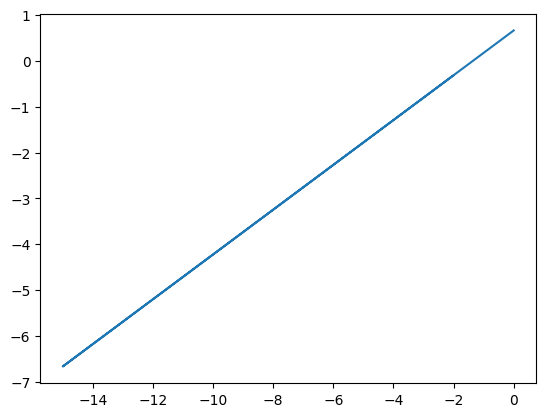

Direction is: 206.02326326416562
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 2.  5.]
 [ 2.  6.]
 [ 2.  7.]
 [ 3.  8.]
 [ 3.  9.]
 [ 3. 10.]
 [ 4. 11.]
 [ 5. 12.]
 [ 6. 13.]
 [ 7. 14.]
 [ 8. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [1.88636364 1.84090909]


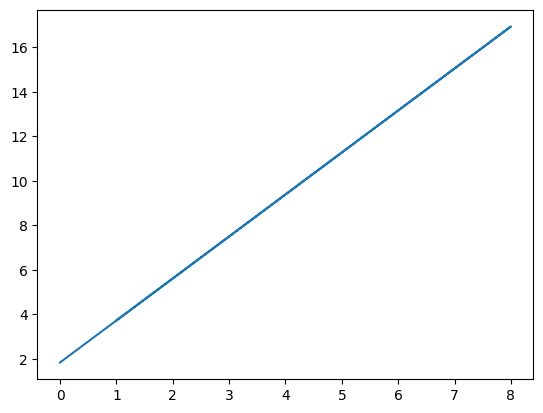

Direction is: 62.0710212913191
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -8.]
 [  9.  -9.]
 [ 10. -10.]
 [ 11. -11.]
 [ 12. -12.]
 [ 13. -13.]
 [ 14. -14.]
 [ 15. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.00000000e+00 -3.06836907e-15]


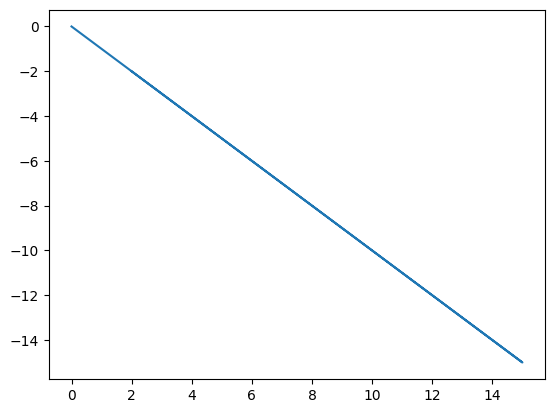

Direction is: 315.0
Sorted vector of angles: [62.0710212913191, 206.02326326416562, 315.0]


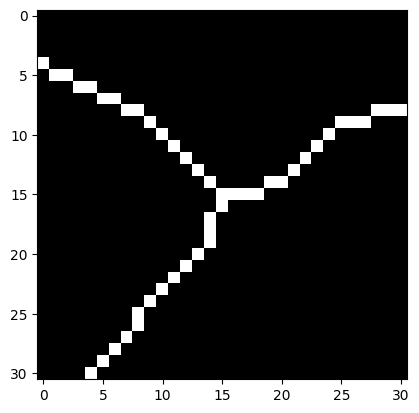

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   6.]
 [ -7.   7.]
 [ -8.   7.]
 [ -9.   8.]
 [-10.   8.]
 [-11.   9.]
 [-12.   9.]
 [-13.  10.]
 [-14.  10.]
 [-15.  11.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.70588235  0.95588235]


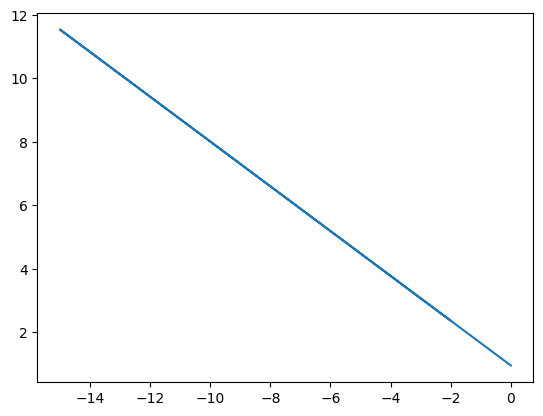

Direction is: 144.78240703180728
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -2.  -5.]
 [ -3.  -6.]
 [ -4.  -7.]
 [ -5.  -8.]
 [ -6.  -9.]
 [ -7. -10.]
 [ -7. -11.]
 [ -8. -12.]
 [ -9. -13.]
 [-10. -14.]
 [-11. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 1.27289322 -1.53331305]


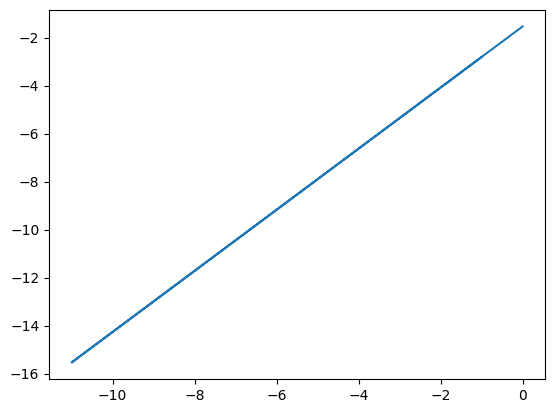

Direction is: 231.84640229249982
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  2.]
 [ 7.  3.]
 [ 8.  4.]
 [ 9.  5.]
 [10.  6.]
 [11.  6.]
 [12.  6.]
 [13.  7.]
 [14.  7.]
 [15.  7.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 0.58382353 -0.94117647]


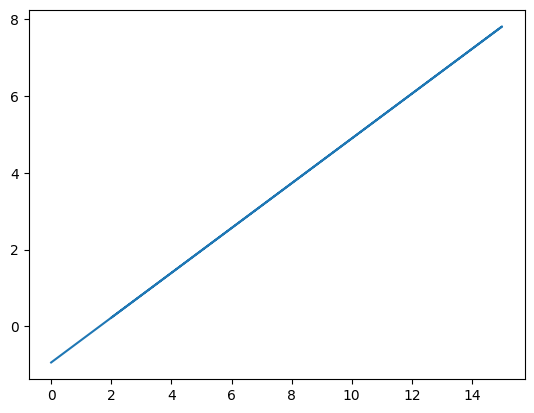

Direction is: 30.277388174392925
Sorted vector of angles: [30.277388174392925, 144.78240703180728, 231.84640229249982]
Descriptors: [[22.954086537628477, 173.4564358992106, 290.03101268089773], [62.0710212913191, 206.02326326416562, 315.0], [30.277388174392925, 144.78240703180728, 231.84640229249982]] for mapbox image 50.76572_3.5426027.jpg
Number of descriptors: 3
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[22.954086537628477, 173.4564358992106, 290.03101268089773]
x = 45.745743357427784, y = 22.954086537628477
x = 168.93332581319532, y = 173.4564358992106
x = 278.29714496983684, y = 290.03101268089773
Result = 26.030785560608706
Descriptor of mapbox image:
[62.0710212913191, 206.02326326416562, 315.0]
x = 45.745743357427784, y = 62.0710212913191
x = 168.93332581319532, y = 206.02326326416562
x = 278.29714496983684, y = 315.0
Result = 54.67428762316763
Descriptor of mapbox image:
[30.277388174392925, 144.7

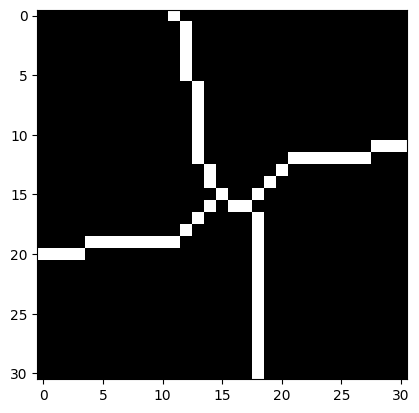

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [-2.  3.]
 [-2.  4.]
 [-2.  5.]
 [-2.  6.]
 [-2.  7.]
 [-2.  8.]
 [-2.  9.]
 [-3. 10.]
 [-3. 11.]
 [-3. 12.]
 [-3. 13.]
 [-3. 14.]
 [-4. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-4.46753247 -2.27272727]


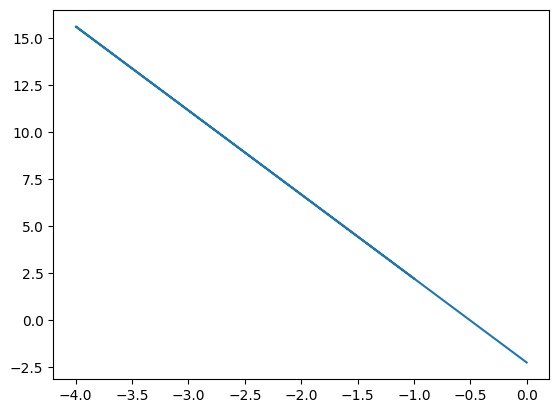

Direction is: 102.6169549927044
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -5.  -4.]
 [ -6.  -4.]
 [ -7.  -4.]
 [ -8.  -4.]
 [ -9.  -4.]
 [-10.  -4.]
 [-11.  -4.]
 [-12.  -5.]
 [-13.  -5.]
 [-14.  -5.]
 [-15.  -5.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.26176471 -1.66176471]


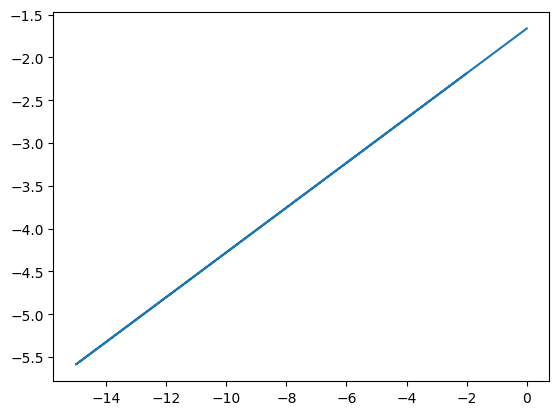

Direction is: 194.6688833688957
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -1.]
 [  3.   0.]
 [  4.   1.]
 [  5.   2.]
 [  6.   3.]
 [  7.   3.]
 [  8.   3.]
 [  9.   3.]
 [ 10.   3.]
 [ 11.   3.]
 [ 12.   3.]
 [ 13.   4.]
 [ 14.   4.]
 [ 15.   4.]
 [  3.  -2.]
 [  3.  -3.]
 [  3.  -4.]
 [  3.  -5.]
 [  3.  -6.]
 [  3.  -7.]
 [  3.  -8.]
 [  3.  -9.]
 [  3. -10.]
 [  3. -11.]
 [  3. -12.]
 [  3. -13.]
 [  3. -14.]
 [  3. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [ 0.95684039 -8.00027144]


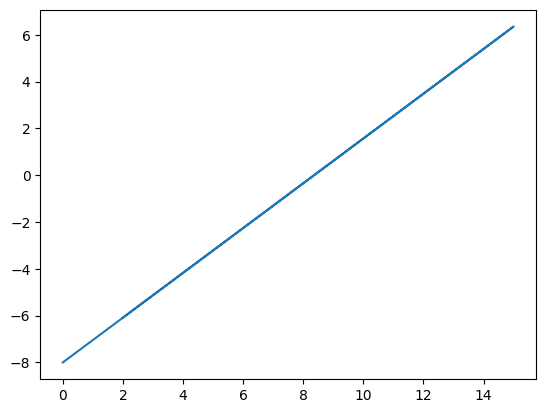

Direction is: 43.73650268247701
Sorted vector of angles: [43.73650268247701, 102.6169549927044, 194.6688833688957]


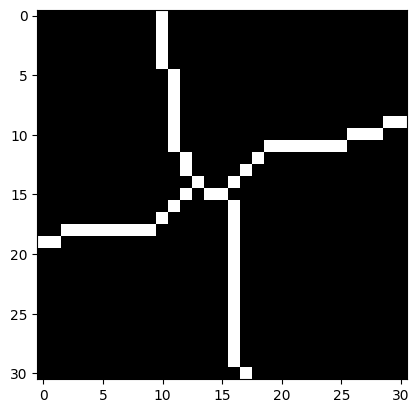

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -4.   5.]
 [ -4.   6.]
 [ -4.   7.]
 [ -4.   8.]
 [ -4.   9.]
 [ -4.  10.]
 [ -5.  11.]
 [ -5.  12.]
 [ -5.  13.]
 [ -5.  14.]
 [ -5.  15.]
 [ -3.   0.]
 [ -4.  -1.]
 [ -5.  -2.]
 [ -6.  -3.]
 [ -7.  -3.]
 [ -8.  -3.]
 [ -9.  -3.]
 [-10.  -3.]
 [-11.  -3.]
 [-12.  -3.]
 [-13.  -3.]
 [-14.  -4.]
 [-15.  -4.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.7662581 7.40534  ]


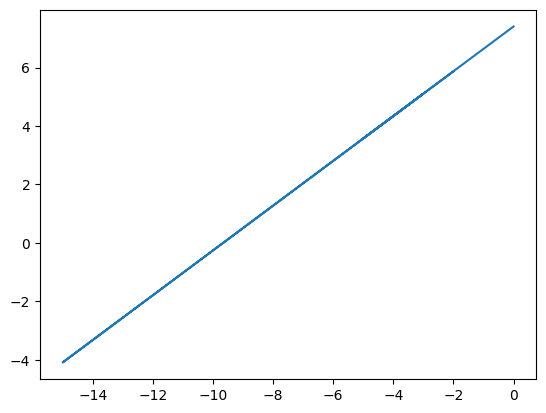

Direction is: 217.46143330563825
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  4.]
 [ 7.  4.]
 [ 8.  4.]
 [ 9.  4.]
 [10.  4.]
 [11.  5.]
 [12.  5.]
 [13.  5.]
 [14.  6.]
 [15.  6.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.31323529 1.46323529]


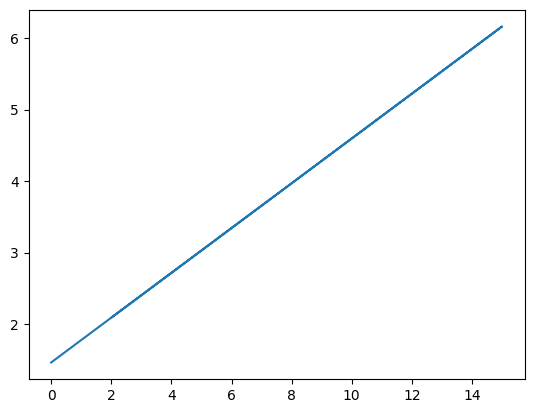

Direction is: 17.39239769340421
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  1.  -7.]
 [  1.  -8.]
 [  1.  -9.]
 [  1. -10.]
 [  1. -11.]
 [  1. -12.]
 [  1. -13.]
 [  1. -14.]
 [  2. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-7.50000000e+00 -1.72438222e-15]


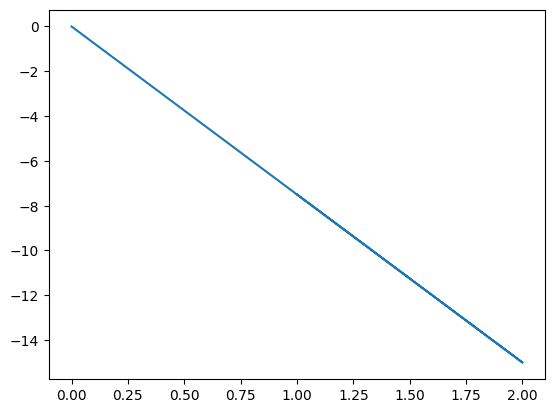

Direction is: 277.59464336859145
Sorted vector of angles: [17.39239769340421, 217.46143330563825, 277.59464336859145]
Descriptors: [[43.73650268247701, 102.6169549927044, 194.6688833688957], [17.39239769340421, 217.46143330563825, 277.59464336859145]] for mapbox image 50.7658722_3.5443585.jpg
Number of descriptors: 2
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[43.73650268247701, 102.6169549927044, 194.6688833688957]
x = 45.745743357427784, y = 43.73650268247701
x = 168.93332581319532, y = 102.6169549927044
x = 278.29714496983684, y = 194.6688833688957
Result = 106.75010175773221
Descriptor of mapbox image:
[17.39239769340421, 217.46143330563825, 277.59464336859145]
x = 45.745743357427784, y = 17.39239769340421
x = 168.93332581319532, y = 217.46143330563825
x = 278.29714496983684, y = 277.59464336859145
Result = 56.208388481092854
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.

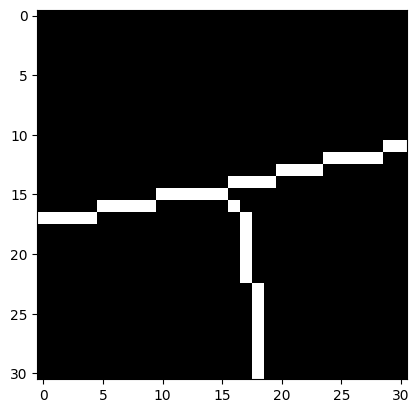

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   0.]
 [ -5.   0.]
 [ -6.  -1.]
 [ -7.  -1.]
 [ -8.  -1.]
 [ -9.  -1.]
 [-10.  -1.]
 [-11.  -2.]
 [-12.  -2.]
 [-13.  -2.]
 [-14.  -2.]
 [-15.  -2.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.16911765 0.33088235]


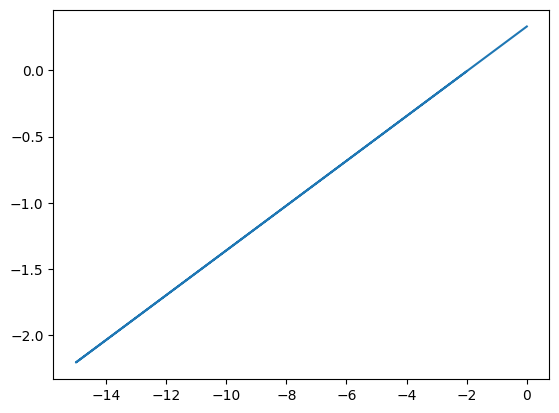

Direction is: 189.5989030685418
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  2.]
 [ 8.  2.]
 [ 9.  3.]
 [10.  3.]
 [11.  3.]
 [12.  3.]
 [13.  3.]
 [14.  4.]
 [15.  4.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.23676471 0.41176471]


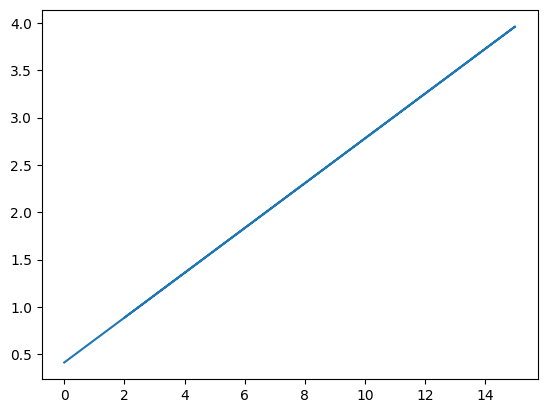

Direction is: 13.320332076914383
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  2.  -5.]
 [  2.  -6.]
 [  2.  -7.]
 [  3.  -8.]
 [  3.  -9.]
 [  3. -10.]
 [  3. -11.]
 [  3. -12.]
 [  3. -13.]
 [  3. -14.]
 [  3. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-4.67759563  3.31693989]


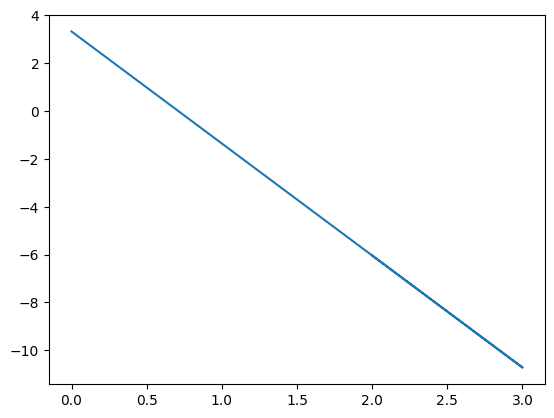

Direction is: 282.06732751898005
Sorted vector of angles: [13.320332076914383, 189.5989030685418, 282.06732751898005]
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.6 -> no intersection in this contour
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.5471274685816876 -> no intersection in this contour
Descriptors: [[13.320332076914383, 189.5989030685418, 282.06732751898005]] for mapbox image 50.7660379_3.5434854.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[13.320332076914383, 189.5989030685418, 282.06732751898005]
x = 45.745743357427784, y = 13.320332076914383
x = 168.93332581319532, y = 189.5989030685418
x = 278.29714496983684, y = 282.06732751898005
Result = 38.63531618171389
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.0]


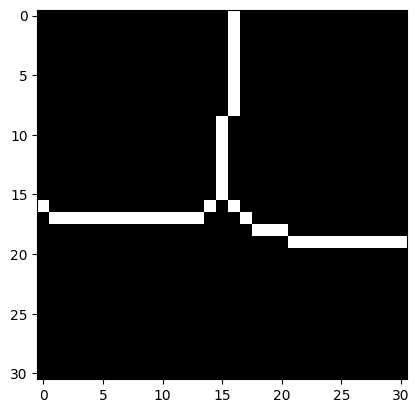

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -2.]
 [ -4.  -2.]
 [ -5.  -2.]
 [ -6.  -2.]
 [ -7.  -2.]
 [ -8.  -2.]
 [ -9.  -2.]
 [-10.  -2.]
 [-11.  -2.]
 [-12.  -2.]
 [-13.  -2.]
 [-14.  -2.]
 [-15.  -1.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.04117647 -1.44117647]


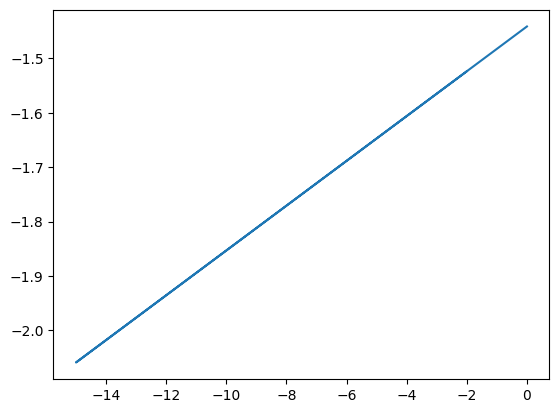

Direction is: 182.3579059707169
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [8. 3.]


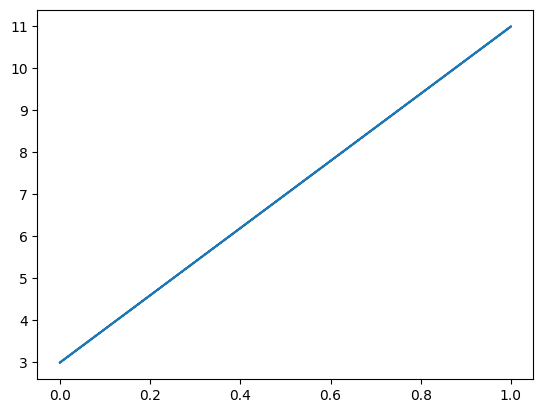

Direction is: 82.8749836510982
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -3.]
 [ 5. -3.]
 [ 6. -4.]
 [ 7. -4.]
 [ 8. -4.]
 [ 9. -4.]
 [10. -4.]
 [11. -4.]
 [12. -4.]
 [13. -4.]
 [14. -4.]
 [15. -4.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.20882353 -1.68382353]


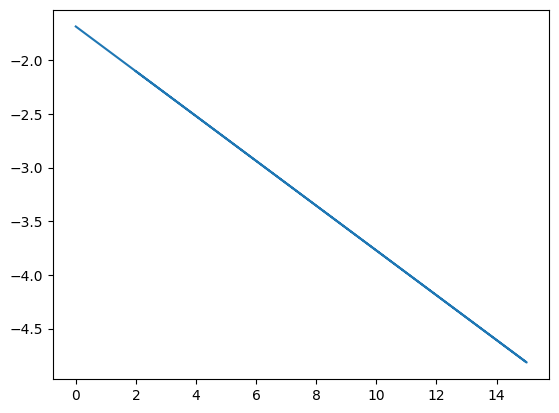

Direction is: 348.2047958476395
Sorted vector of angles: [82.8749836510982, 182.3579059707169, 348.2047958476395]
Descriptors: [[82.8749836510982, 182.3579059707169, 348.2047958476395]] for mapbox image 50.7663914_3.5414129.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[82.8749836510982, 182.3579059707169, 348.2047958476395]
x = 45.745743357427784, y = 82.8749836510982
x = 168.93332581319532, y = 182.3579059707169
x = 278.29714496983684, y = 348.2047958476395
Result = 80.28623473823882
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.0]
Descriptor of mapbox image:
[82.8749836510982, 182.3579059707169, 348.2047958476395]
x = 71.88693419247672, y = 82.8749836510982
x = 201.72873603532827, y = 182.3579059707169
x = 315.0, y = 348.2047958476395
Result = 39.981555192120545
**************************************************
Mapbox image: 50.763079_3.5406427.j

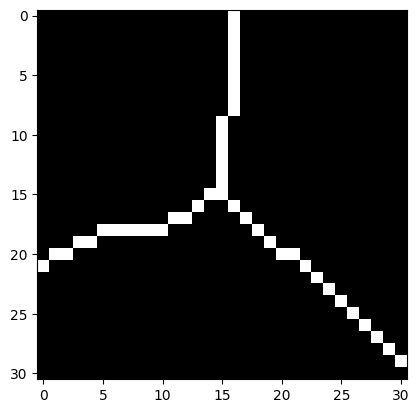

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -2.]
 [ -4.  -2.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -3.]
 [ -8.  -3.]
 [ -9.  -3.]
 [-10.  -3.]
 [-11.  -4.]
 [-12.  -4.]
 [-13.  -5.]
 [-14.  -5.]
 [-15.  -6.]
 [ -1.   0.]
 [  0.   0.]]
Line: [ 0.33970588 -0.38970588]


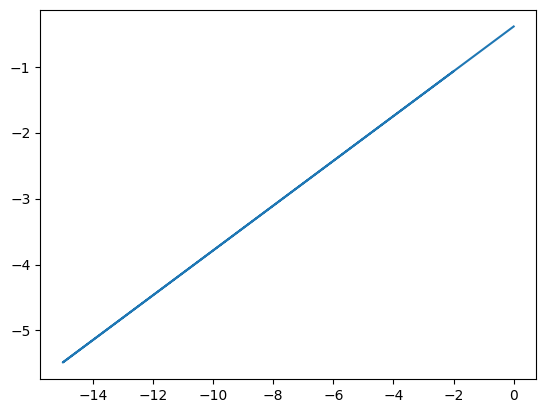

Direction is: 198.76292636501273
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [8. 3.]


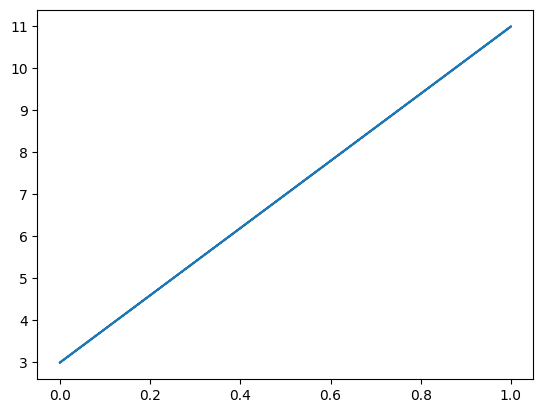

Direction is: 82.8749836510982
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -5.]
 [  7.  -6.]
 [  8.  -7.]
 [  9.  -8.]
 [ 10.  -9.]
 [ 11. -10.]
 [ 12. -11.]
 [ 13. -12.]
 [ 14. -13.]
 [ 15. -14.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.91176471 -0.03676471]


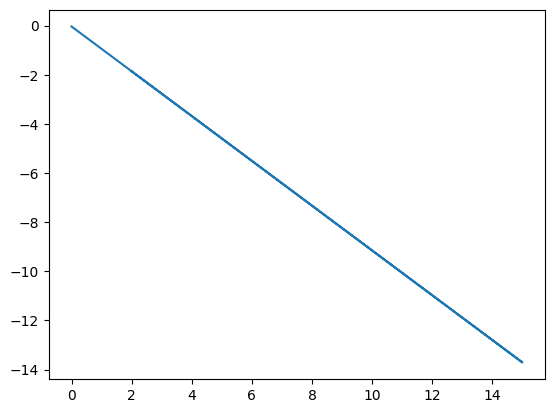

Direction is: 317.64254529406475
Sorted vector of angles: [82.8749836510982, 198.76292636501273, 317.64254529406475]


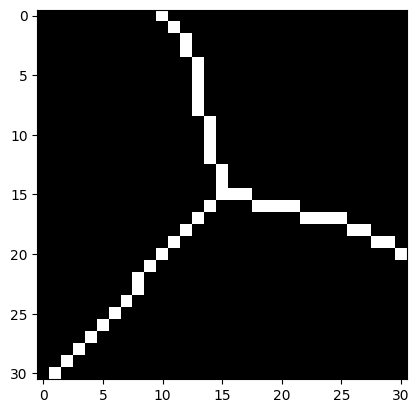

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -5.  -5.]
 [ -6.  -6.]
 [ -7.  -7.]
 [ -7.  -8.]
 [ -8.  -9.]
 [ -9. -10.]
 [-10. -11.]
 [-11. -12.]
 [-12. -13.]
 [-13. -14.]
 [-14. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.1 0.2]


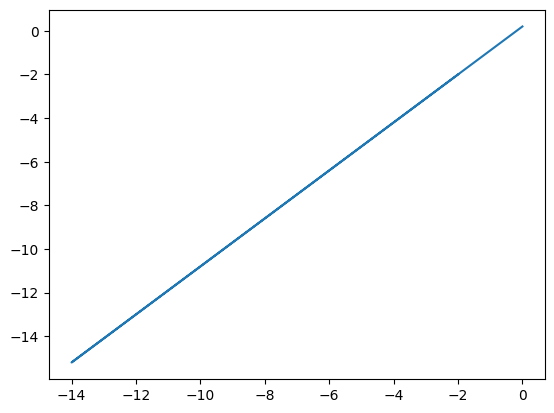

Direction is: 227.72631099390625
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [-1.  3.]
 [-1.  4.]
 [-1.  5.]
 [-1.  6.]
 [-2.  7.]
 [-2.  8.]
 [-2.  9.]
 [-2. 10.]
 [-2. 11.]
 [-3. 12.]
 [-3. 13.]
 [-4. 14.]
 [-5. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-3.17043121  1.75359343]


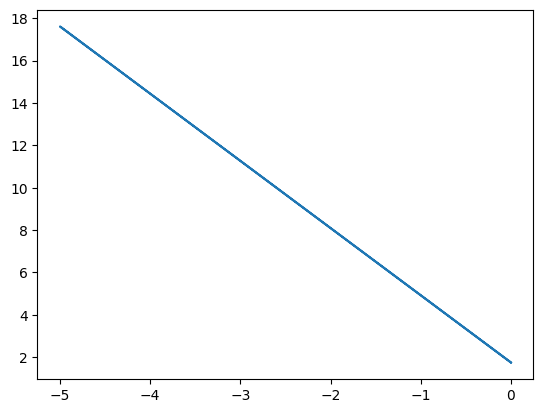

Direction is: 107.5060304745904
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3. -1.]
 [ 4. -1.]
 [ 5. -1.]
 [ 6. -1.]
 [ 7. -2.]
 [ 8. -2.]
 [ 9. -2.]
 [10. -2.]
 [11. -3.]
 [12. -3.]
 [13. -4.]
 [14. -4.]
 [15. -5.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.31029412  0.38970588]


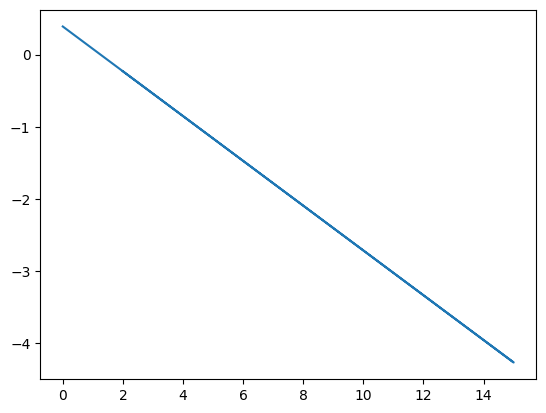

Direction is: 342.7611908522036
Sorted vector of angles: [107.5060304745904, 227.72631099390625, 342.7611908522036]
Descriptors: [[82.8749836510982, 198.76292636501273, 317.64254529406475], [107.5060304745904, 227.72631099390625, 342.7611908522036]] for mapbox image 50.763079_3.5406427.jpg
Number of descriptors: 2
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[82.8749836510982, 198.76292636501273, 317.64254529406475]
x = 45.745743357427784, y = 82.8749836510982
x = 168.93332581319532, y = 198.76292636501273
x = 278.29714496983684, y = 317.64254529406475
Result = 61.77739133809276
Descriptor of mapbox image:
[107.5060304745904, 227.72631099390625, 342.7611908522036]
x = 45.745743357427784, y = 107.5060304745904
x = 168.93332581319532, y = 227.72631099390625
x = 278.29714496983684, y = 342.7611908522036
Result = 106.89509522320256
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.0]
D

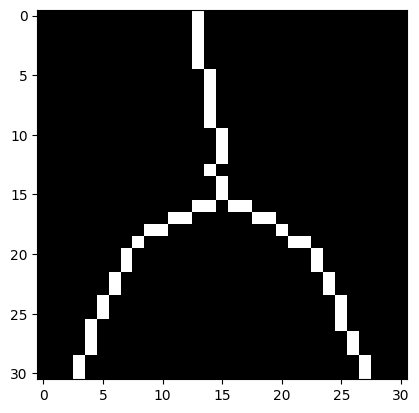

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -2.]
 [ -4.  -2.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -4.]
 [ -8.  -5.]
 [ -8.  -6.]
 [ -9.  -7.]
 [ -9.  -8.]
 [-10.  -9.]
 [-10. -10.]
 [-11. -11.]
 [-11. -12.]
 [-11. -13.]
 [-12. -14.]
 [-12. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.18593065 2.04444002]


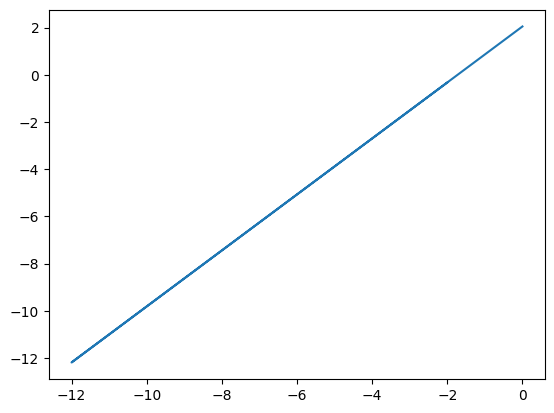

Direction is: 229.86175598706154
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [-1.  6.]
 [-1.  7.]
 [-1.  8.]
 [-1.  9.]
 [-1. 10.]
 [-2. 11.]
 [-2. 12.]
 [-2. 13.]
 [-2. 14.]
 [-2. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-5.2  2.3]


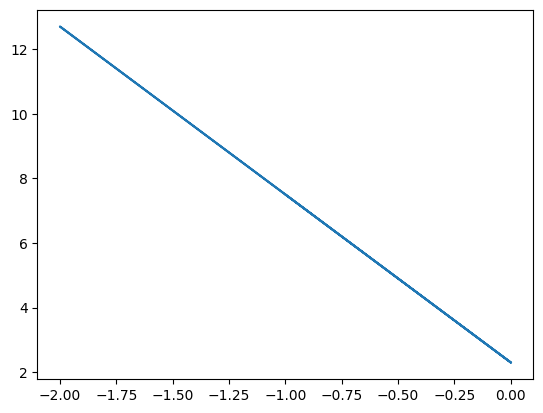

Direction is: 100.88552705465874
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -1.]
 [  3.  -2.]
 [  4.  -2.]
 [  5.  -3.]
 [  6.  -4.]
 [  7.  -4.]
 [  8.  -5.]
 [  8.  -6.]
 [  9.  -7.]
 [  9.  -8.]
 [ 10.  -9.]
 [ 10. -10.]
 [ 10. -11.]
 [ 11. -12.]
 [ 11. -13.]
 [ 12. -14.]
 [ 12. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.19362745  1.98529412]


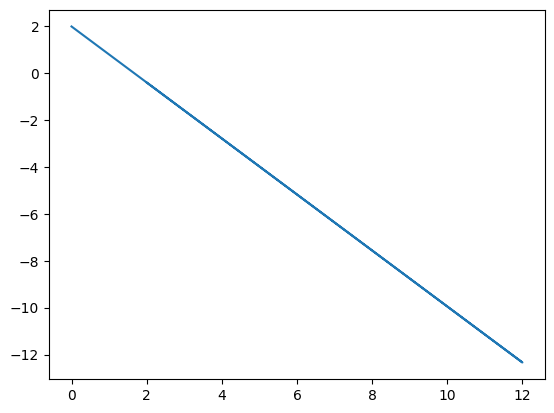

Direction is: 309.9556806105013
Sorted vector of angles: [100.88552705465874, 229.86175598706154, 309.9556806105013]
Descriptors: [[100.88552705465874, 229.86175598706154, 309.9556806105013]] for mapbox image 50.764544_3.5377325.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[100.88552705465874, 229.86175598706154, 309.9556806105013]
x = 45.745743357427784, y = 100.88552705465874
x = 168.93332581319532, y = 229.86175598706154
x = 278.29714496983684, y = 309.9556806105013
Result = 88.06209302838725
Descriptor of segmentation image:
[71.88693419247672, 201.72873603532827, 315.0]
Descriptor of mapbox image:
[100.88552705465874, 229.86175598706154, 309.9556806105013]
x = 71.88693419247672, y = 100.88552705465874
x = 201.72873603532827, y = 229.86175598706154
x = 315.0, y = 309.9556806105013
Result = 40.71646298113932
**************************************************
Mapbox image: 50.76

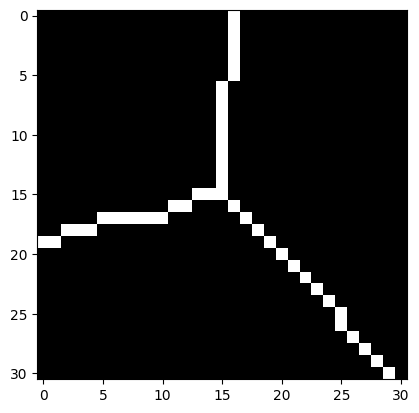

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.  -1.]
 [ -4.  -1.]
 [ -5.  -2.]
 [ -6.  -2.]
 [ -7.  -2.]
 [ -8.  -2.]
 [ -9.  -2.]
 [-10.  -2.]
 [-11.  -3.]
 [-12.  -3.]
 [-13.  -3.]
 [-14.  -4.]
 [-15.  -4.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.26029412 0.01470588]


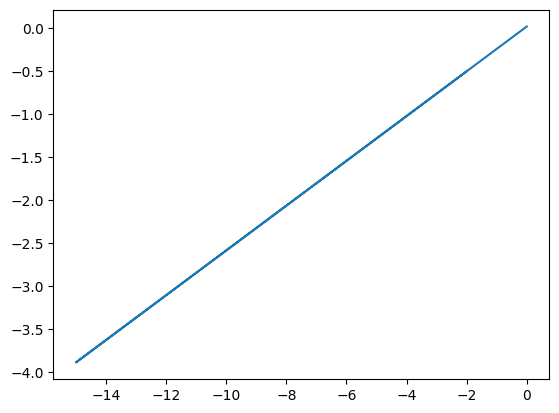

Direction is: 194.58999972412997
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 1. 14.]
 [ 1. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [8.  4.5]


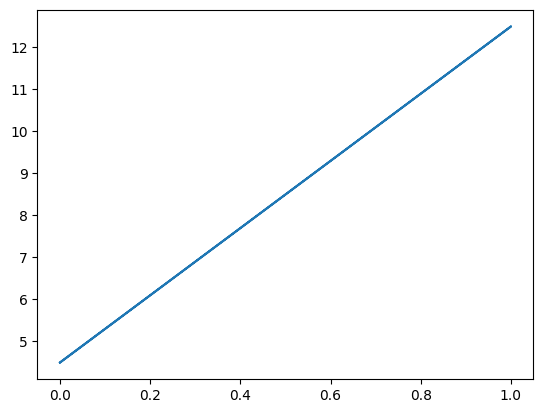

Direction is: 82.87498365109822
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -8.]
 [  9.  -9.]
 [ 10. -10.]
 [ 10. -11.]
 [ 11. -12.]
 [ 12. -13.]
 [ 13. -14.]
 [ 14. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.08342362  0.28710726]


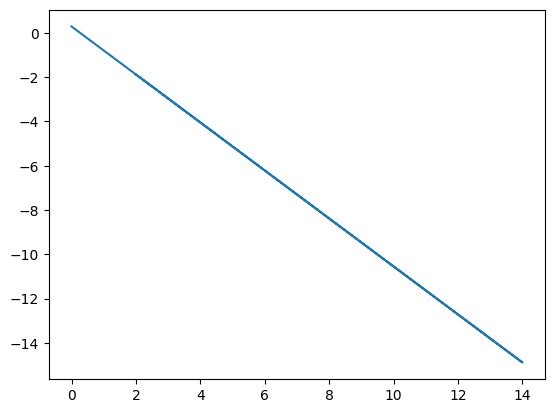

Direction is: 312.70701016921225
Sorted vector of angles: [82.87498365109822, 194.58999972412997, 312.70701016921225]


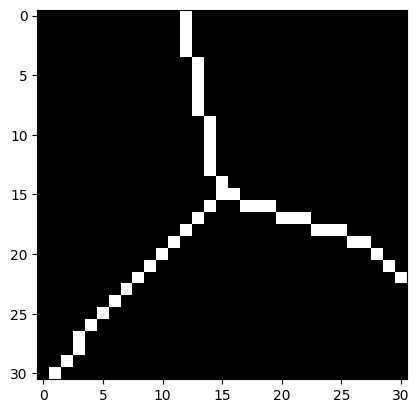

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -4.]
 [ -5.  -5.]
 [ -6.  -6.]
 [ -7.  -7.]
 [ -8.  -8.]
 [ -9.  -9.]
 [-10. -10.]
 [-11. -11.]
 [-12. -12.]
 [-12. -13.]
 [-13. -14.]
 [-14. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.05623069 0.22368692]


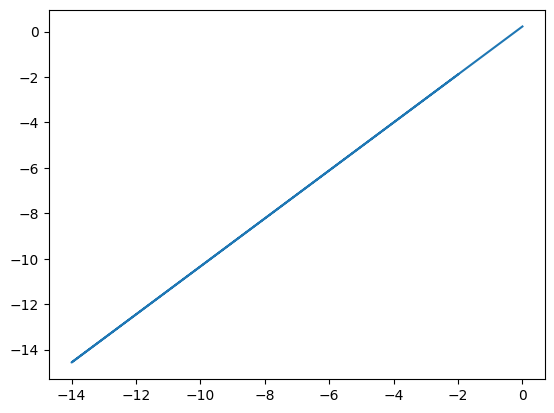

Direction is: 226.56644800465824
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [-1.  3.]
 [-1.  4.]
 [-1.  5.]
 [-1.  6.]
 [-2.  7.]
 [-2.  8.]
 [-2.  9.]
 [-2. 10.]
 [-2. 11.]
 [-3. 12.]
 [-3. 13.]
 [-3. 14.]
 [-3. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-4.50202429 -0.09716599]


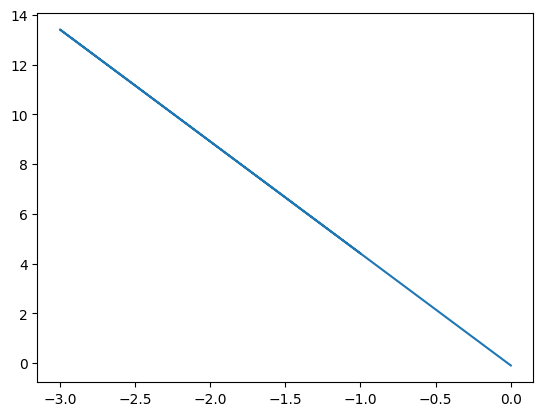

Direction is: 102.52335200744326
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -1.]
 [ 3. -1.]
 [ 4. -1.]
 [ 5. -2.]
 [ 6. -2.]
 [ 7. -2.]
 [ 8. -3.]
 [ 9. -3.]
 [10. -3.]
 [11. -4.]
 [12. -4.]
 [13. -5.]
 [14. -6.]
 [15. -7.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.41764706  0.38235294]


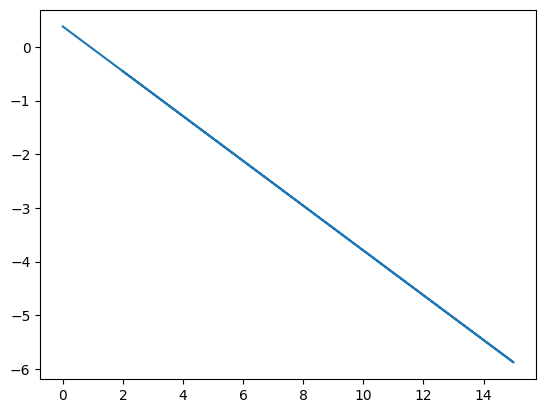

Direction is: 337.33228890064873
Sorted vector of angles: [102.52335200744326, 226.56644800465824, 337.33228890064873]
Descriptors: [[82.87498365109822, 194.58999972412997, 312.70701016921225], [102.52335200744326, 226.56644800465824, 337.33228890064873]] for mapbox image 50.7629072_3.5407101.jpg
Number of descriptors: 2
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[82.87498365109822, 194.58999972412997, 312.70701016921225]
x = 45.745743357427784, y = 82.87498365109822
x = 168.93332581319532, y = 194.58999972412997
x = 278.29714496983684, y = 312.70701016921225
Result = 56.752834501867326
Descriptor of mapbox image:
[102.52335200744326, 226.56644800465824, 337.33228890064873]
x = 45.745743357427784, y = 102.52335200744326
x = 168.93332581319532, y = 226.56644800465824
x = 278.29714496983684, y = 337.33228890064873
Result = 100.15199367202875
Descriptor of segmentation image:
[71.88693419247672, 201.7287360353

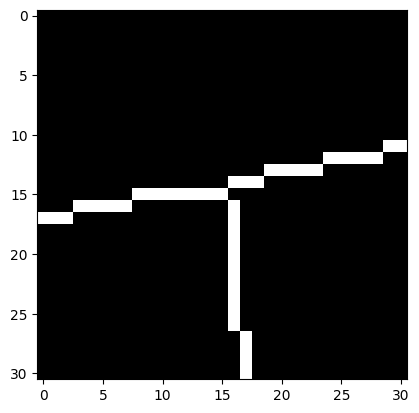

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   0.]
 [ -5.   0.]
 [ -6.   0.]
 [ -7.   0.]
 [ -8.  -1.]
 [ -9.  -1.]
 [-10.  -1.]
 [-11.  -1.]
 [-12.  -1.]
 [-13.  -2.]
 [-14.  -2.]
 [-15.  -2.]
 [ -1.   0.]
 [  0.   0.]]
Line: [0.15147059 0.44852941]


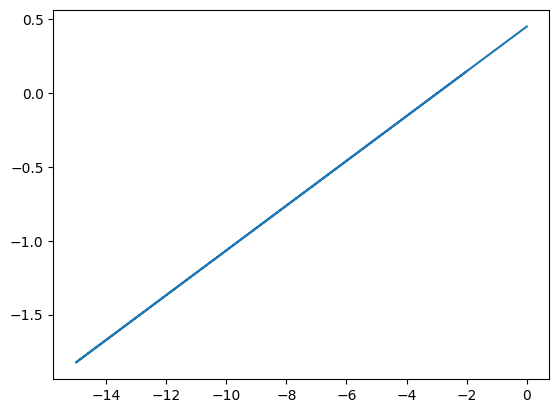

Direction is: 188.61315217983056
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  2.]
 [ 8.  2.]
 [ 9.  3.]
 [10.  3.]
 [11.  3.]
 [12.  3.]
 [13.  3.]
 [14.  4.]
 [15.  4.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.22647059 0.55147059]


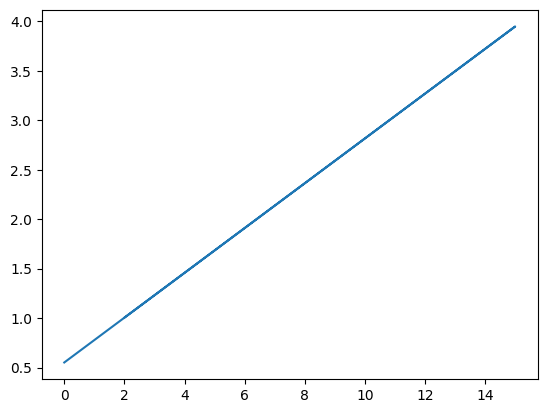

Direction is: 12.760556642478234
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  1.  -7.]
 [  1.  -8.]
 [  1.  -9.]
 [  1. -10.]
 [  1. -11.]
 [  2. -12.]
 [  2. -13.]
 [  2. -14.]
 [  2. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-7.09859155  0.92957746]


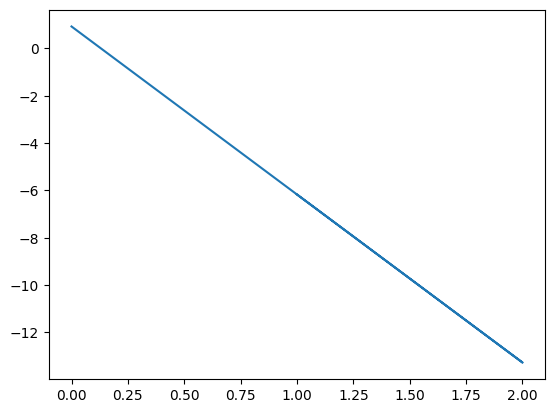

Direction is: 278.01866307912195
Sorted vector of angles: [12.760556642478234, 188.61315217983056, 278.01866307912195]


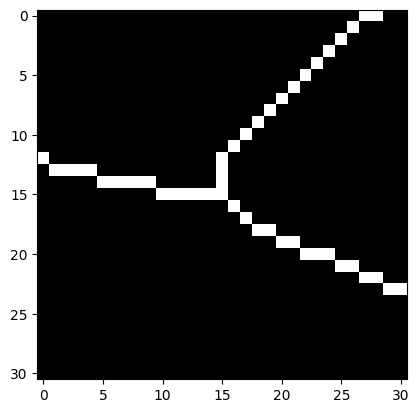

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.   0.]
 [ -5.   0.]
 [ -6.   1.]
 [ -7.   1.]
 [ -8.   1.]
 [ -9.   1.]
 [-10.   1.]
 [-11.   2.]
 [-12.   2.]
 [-13.   2.]
 [-14.   2.]
 [-15.   3.]
 [ -1.   0.]
 [  0.   0.]]
Line: [-0.19117647 -0.43382353]


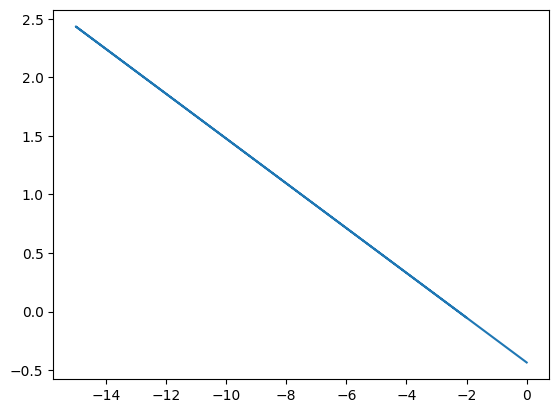

Direction is: 169.1769887737929
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 1.  4.]
 [ 2.  5.]
 [ 3.  6.]
 [ 4.  7.]
 [ 5.  8.]
 [ 6.  9.]
 [ 7. 10.]
 [ 8. 11.]
 [ 9. 12.]
 [10. 13.]
 [11. 14.]
 [12. 15.]
 [13. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [1.07373272 2.19354839]


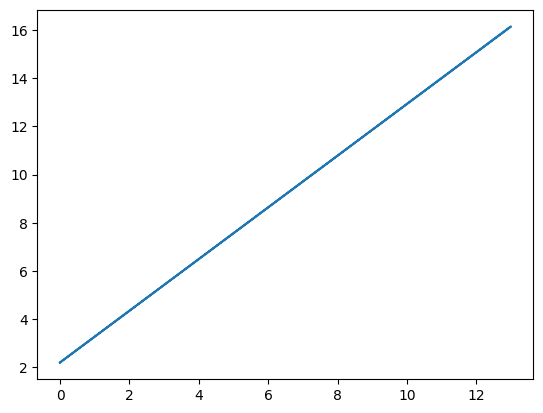

Direction is: 47.03632545479828
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -3.]
 [ 5. -4.]
 [ 6. -4.]
 [ 7. -5.]
 [ 8. -5.]
 [ 9. -5.]
 [10. -6.]
 [11. -6.]
 [12. -7.]
 [13. -7.]
 [14. -8.]
 [15. -8.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.49411765 -0.91911765]


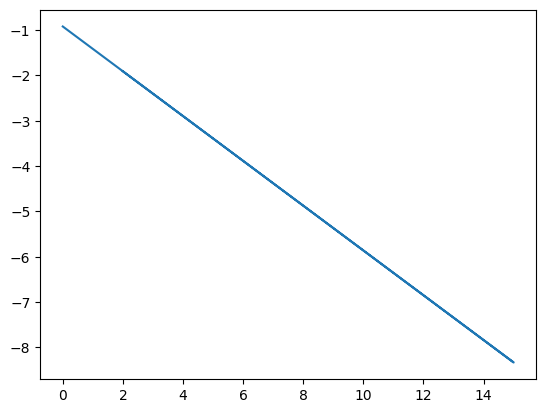

Direction is: 333.7052099294161
Sorted vector of angles: [47.03632545479828, 169.1769887737929, 333.7052099294161]


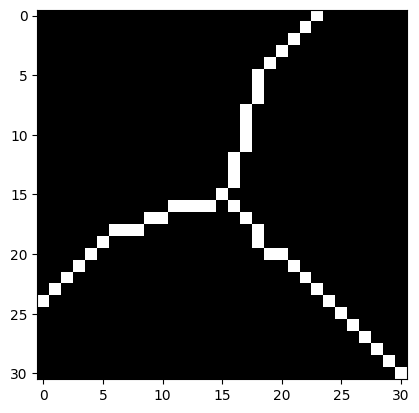

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -1.]
 [ -5.  -2.]
 [ -6.  -2.]
 [ -7.  -3.]
 [ -8.  -3.]
 [ -9.  -3.]
 [-10.  -4.]
 [-11.  -5.]
 [-12.  -6.]
 [-13.  -7.]
 [-14.  -8.]
 [-15.  -9.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [0.55588235 0.66911765]


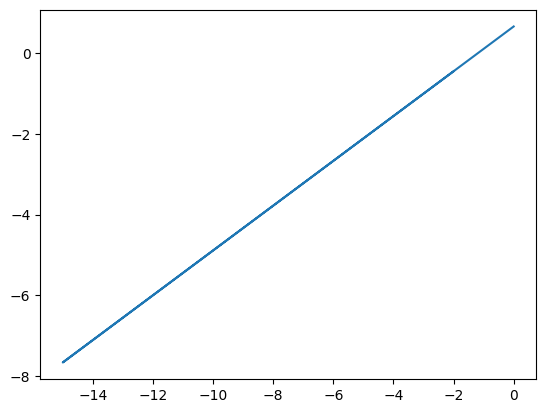

Direction is: 209.06891016108023
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 1.  3.]
 [ 2.  4.]
 [ 2.  5.]
 [ 2.  6.]
 [ 2.  7.]
 [ 3.  8.]
 [ 3.  9.]
 [ 3. 10.]
 [ 4. 11.]
 [ 5. 12.]
 [ 6. 13.]
 [ 7. 14.]
 [ 8. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [1.95611285 1.38714734]


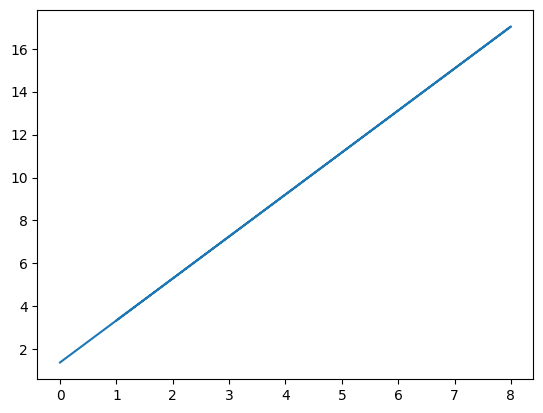

Direction is: 62.92306651813769
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  3.  -4.]
 [  4.  -5.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -8.]
 [  9.  -9.]
 [ 10. -10.]
 [ 11. -11.]
 [ 12. -12.]
 [ 13. -13.]
 [ 14. -14.]
 [ 15. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.97919397 -0.2681848 ]


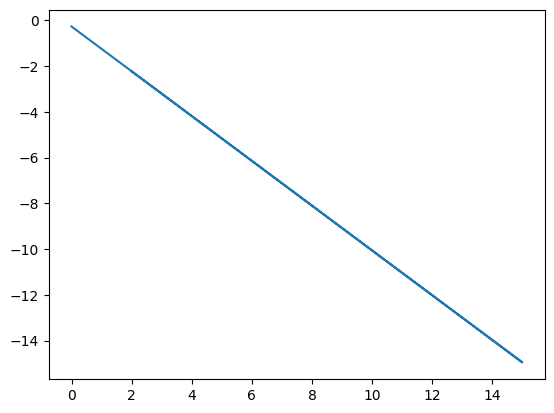

Direction is: 315.6022925230951
Sorted vector of angles: [62.92306651813769, 209.06891016108023, 315.6022925230951]


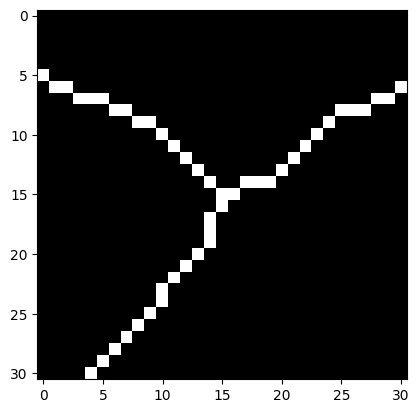

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   6.]
 [ -7.   6.]
 [ -8.   7.]
 [ -9.   7.]
 [-10.   8.]
 [-11.   8.]
 [-12.   8.]
 [-13.   9.]
 [-14.   9.]
 [-15.  10.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.62205882  1.14705882]


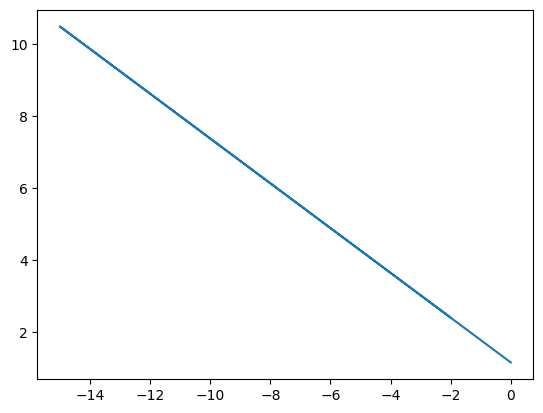

Direction is: 148.11595777162145
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -2.  -5.]
 [ -3.  -6.]
 [ -4.  -7.]
 [ -5.  -8.]
 [ -5.  -9.]
 [ -6. -10.]
 [ -7. -11.]
 [ -8. -12.]
 [ -9. -13.]
 [-10. -14.]
 [-11. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 1.28790247 -1.62394498]


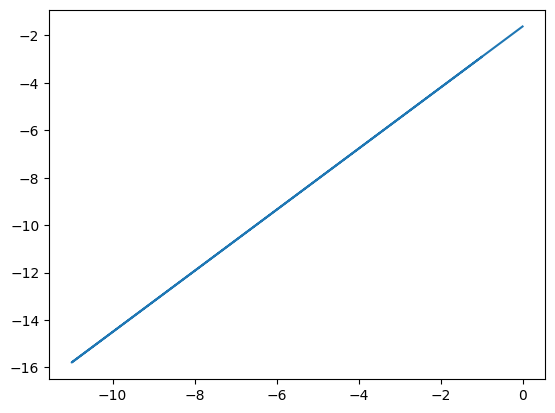

Direction is: 232.17222251911153
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  2.]
 [ 6.  3.]
 [ 7.  4.]
 [ 8.  5.]
 [ 9.  6.]
 [10.  7.]
 [11.  7.]
 [12.  7.]
 [13.  8.]
 [14.  8.]
 [15.  9.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 0.65735294 -0.61764706]


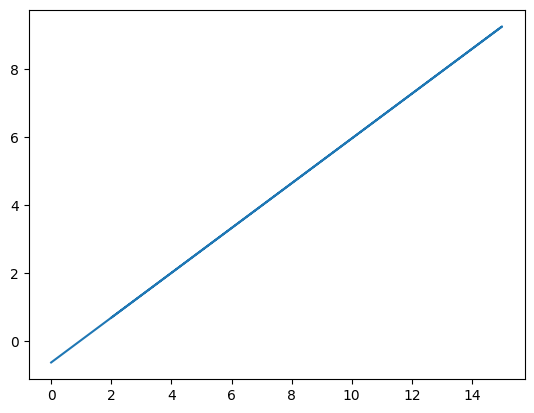

Direction is: 33.319036648788675
Sorted vector of angles: [33.319036648788675, 148.11595777162145, 232.17222251911153]
Descriptors: [[12.760556642478234, 188.61315217983056, 278.01866307912195], [47.03632545479828, 169.1769887737929, 333.7052099294161], [62.92306651813769, 209.06891016108023, 315.6022925230951], [33.319036648788675, 148.11595777162145, 232.17222251911153]] for mapbox image 50.765399_3.5427992.jpg
Number of descriptors: 4
Descriptor of segmentation image:
[45.745743357427784, 168.93332581319532, 278.29714496983684]
Descriptor of mapbox image:
[12.760556642478234, 188.61315217983056, 278.01866307912195]
x = 45.745743357427784, y = 12.760556642478234
x = 168.93332581319532, y = 188.61315217983056
x = 278.29714496983684, y = 278.01866307912195
Result = 38.41087945627452
Descriptor of mapbox image:
[47.03632545479828, 169.1769887737929, 333.7052099294161]
x = 45.745743357427784, y = 47.03632545479828
x = 168.93332581319532, y = 169.1769887737929
x = 278.29714496983684, y = 

In [20]:
best_mb_image = None
lowest_score = 1000

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    score = 0
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image)
    print(f"Descriptors: {des} for mapbox image {mb_image}")

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_ in des :
                print(f"Descriptor of mapbox image:")
                print(des_)

                if len(des_segm) == len(des_) : 
                    result = 0
                    for x, y in zip(des_segm, des_) :
                        print(f"x = {x}, y = {y}")
                        result += (x-y)**2
                    result = math.sqrt(result)
                elif len(des_) > len(des_segm) :
                    for x in des_segm : 
                        best_diff = 1000
                        for y in des_ :
                            diff = abs(x-y)
                            if diff < best_diff :
                                best_diff = diff
                        result += best_diff**2
                    result = math.sqrt(result)
                else :
                    # this can't be the case 
                    continue

                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result
            
            score += best_result_per_des
        
        if score < lowest_score :
            lowest_score = score
            best_mb_image = mb_image
    else:
        continue

print(f"Lowest score = {lowest_score} with mapbox image {best_mb_image}")